# Previsão de Inadimplência utilizando Técnicas de Credit Scoring e Machine Learning
Projeto desenvolvido por Thiago Bulgarelli

## Contextualização

A análise de riscos em cartões de crédito é um campo fundamental dentro do setor financeiro, que busca garantir a segurança das transações e a proteção tanto dos consumidores quanto das instituições financeiras.

A crescente popularidade do uso de cartões de crédito como meio de pagamento tem gerado um ambiente complexo e desafiador, no qual a detecção precoce de possíveis ameaças é essencial para evitar prejuízos financeiros significativos.

Um dos principais pilares da análise de riscos em cartões de crédito é a avaliação do histórico de pagamento do titular do cartão. Esse aspecto inclui a análise de como o cliente tem gerenciado suas dívidas e honrado seus compromissos financeiros no passado. A análise do histórico de pagamento é frequentemente realizada por meio de sistemas de pontuação de crédito, como o FICO Score nos EUA, que avaliam o risco de inadimplência com base em vários fatores, incluindo histórico de pagamento, dívidas atuais, duração do histórico de crédito e outros.

Outro ponto crítico na análise de riscos em cartões de crédito é a detecção de atividades suspeitas e a prevenção de fraudes. Isso envolve o monitoramento constante de transações em busca de padrões incomuns que possam indicar uma fraude em andamento. Técnicas avançadas, como aprendizado de máquina e anáise de Big Data, são frequentemente utilizadas para identificar comportamentos fraudulentos e tomar medidas rápidas para proteger os consumidores e as instituições financeiras.

A análise de riscos em cartões de crédito é uma discplina dinâmica e em constante evolução, essencial para garantir a estabilidade e a segurança do sistema financeiro. Ela desempenha um papel crucial na concessão responsável de crédito e na prevenção de fraudes, contribuindo para a confiança dos consumidores e a saúde financeira das instituições.

## Estudo Técnico Aplicado

Utilizando dados públicos, disponibilizados na plataforma do Kaggle pelo link https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction, nosso objetivo final é entregar a etapa de análise das variáveis, um dataset limpo, organizado e com a variável resposta bem cosntruída.

Como poderemos observar, não teremos uma classificação em bons pagadores e maus pagadores, porém teremos as ocorrências mensais de inadimplência em janelas de tempos. Podemos utilizar uma técnica chamada de *Vintage Analysis* para identificar uma janela representativa e então com a ajuda de algumas definições de negócio, aplicar regras na construção da variável resposta.

### Sobre o Dataset

Os datasets disponibilizados conta com o seguinte detalhamento:

Dataset: application_record.csv
- ID = Identificador do Cliente
- CODE_GENDER = Gênero do Cliente
- FLAG_OWN_CAR = Refere-se a propriedade de carro pelo cliente
- FLAG_OWN_REALTY = Refere-se a propriedade residencial pelo cliente
- CNT_CHILDREN = Número de Filhos do Cliente
- AMT_INCOME_TOTAL = Receita Anual do Cliente
- NAME_INCOME_TYPE = Origem da Receita do Cliente
- NAME_EDUCATION_TYPE = Grau de Formação do Cliente
- NAME_FAMILY_STATUS = Estado Civil do Cliente
- NAME_HOUSING_TYPE = Tipo de Moradia
- DAYS_BIRTH = Data do Aniversário relativa ao dia atual (hoje = 0)
- DAYS_EMPLOYED = Total de dias Desempregado (valor positivo) e Empregado (Valor Negativo)
- FLAG_MOBILE = Refere-se a propriedade de Celular do Cliente
- FLAG_WORK_PHONE = Refere-se a propriedade de telefone corporativo do Cliente
- FLAG_PHONE = Refere-se a propriedade de telefone fixo do cliente
- FLAG_EMAIL = Refere-se a propriedade de Email do Cliente
- OCCUPATION_TYPE = Tipo de Ocupação do Cliente
- CNT_FAM_MEMBERS = Quantidade de pessoas na família do Cliente

Dataset: credit_record.csv
- ID = Identificador do Cliente
- MONTHS_BALANCE = Medida relativa do mês devedor, sendo 0 o mês atual
- STATUS = Tempo de Atraso nos Pagamentos DPD (Days Past Due): 
    - 0 - 1-29 dias, 
    - 1 - 30-59 dias, 
    - 2 - 60-89 dias, 
    - 3 - 90-119 dias, 
    - 4 - 120-149 dias, 
    - 5 - dividas baixadas com mais de 150 dias, 
    - C - Quitado no mês, 
    - X - Nenhum empréstimo no mês


### Carregando Pacotes e Definindo Funções

In [4]:
# Pacotes de Trabalho
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as scp
from statsmodels.stats.proportion import proportions_ztest
import sklearn as skl
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

In [5]:
# Funções Úteis
def clean_data(dataset):
    # Drop dados duplicados, referenciando a coluna ID
    client_data = dataset.drop_duplicates(subset=['ID'])
    # Aplicando a categoria "Nao_Informado" a Ocupacao com dados faltantes (NaN) com dias_empregados negativos
    cond = (client_data['OCCUPATION_TYPE'].isna() == True) & (client_data['DAYS_EMPLOYED'] < 0)
    client_data.loc[cond, 'OCCUPATION_TYPE'] = 'Not Informed'

    # Aplicando a categoria "Desempregado" a Ocupacao com dados faltantes (NaN) com dias_empregados positivos
    cond = (client_data['OCCUPATION_TYPE'].isna() == True) & (client_data['DAYS_EMPLOYED'] > 0)
    client_data.loc[cond, 'OCCUPATION_TYPE'] = 'Unemployed'

    return client_data

def box_graf(dataset, independente, resposta):
    # Construindo o boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=dataset, x=resposta, y=independente, palette="Set3")

    # Formatação para apresentação 

    # Tema
    sns.set_theme(style="whitegrid", palette="pastel")

    # Título
    plt.title(f"Medidas de Dispersão e Posição de {independente} por Classe de {resposta}", fontsize=14)

    # Eixos
    plt.xlabel("", fontsize=12)
    plt.ylabel(f"{independente}", fontsize=12)

    # Fonte
    plt.tick_params(labelsize=10)

    # Margens
    plt.tight_layout()

    # Mostrar o gráfico
    plt.show()

def comp_cat(dataset, independente, resposta, ordem=None):
    # Criando uma figura com dois subplots (lado a lado)
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # Se a ordem não for especificada, determina a ordem com base em todos os dados disponíveis para essa variável
    if ordem is None:
        ordem = dataset[independente].value_counts().index

    for i, tipo in enumerate(['BOM PAGADOR', 'MAU PAGADOR']):
        # Filtrando o dataset conforme o tipo de pagador
        subset = dataset[dataset[resposta] == tipo]
        
        # Criando o countplot
        sns.countplot(data=subset, x=independente, ax=axs[i], color='lightgreen' if tipo == 'BOM PAGADOR' else 'lightcoral', order=ordem)
        axs[i].set_title(f'Distribuição de {independente} entre {tipo}', fontsize=16)
        axs[i].set_xlabel(independente)
        axs[i].set_ylabel('Contagem')
        axs[i].grid(False)  # Desabilitando as linhas de grade
        
        # Rotacionando os rótulos do eixo x
        axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, ha="right")

        # Calculando as contagens e proporções
        contagem = subset[independente].value_counts().reindex(ordem).fillna(0)
        proporcoes = (contagem / contagem.sum() * 100).round(2)
        
        # Adicionando rótulos de contagem nas barras
        for p, value in zip(axs[i].patches, contagem):
            axs[i].text(p.get_x() + p.get_width() / 2., p.get_height(), f'{int(value)}', ha='center', va='bottom', fontsize=10)
        
        # Plotando as proporções com eixo y secundário
        ax2 = axs[i].twinx()
        ax2.plot(axs[i].get_xticks(), proporcoes, color='blue', marker='o', linestyle='-', linewidth=2.0)
        ax2.set_ylabel('Proporção (%)')
        ax2.set_ylim(0, 100)  # Definindo a escala de 0 a 100 para proporções percentuais

        # # Adicionando rótulos de proporção nos pontos
        # for idx, (prop, value) in enumerate(zip(axs[i].get_xticks(), proporcoes)):
        #     ax2.text(prop, value + 2.5, f'{value}%', ha='right', va='bottom', color='blue', fontsize=10)

    # Ajustando o layout para evitar sobreposição de títulos e rótulos
    plt.tight_layout()
    plt.show()

def elimina_outliers(dataset, independente):
    # Calcula quartis 
    Q1 = dataset[independente].quantile(0.25)
    Q3 = dataset[independente].quantile(0.75)
    IQR = Q3 - Q1

    # Define limites com base no IQR (ex: 1.5 IQR)
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    # Filtra os dados dentro dos limites
    df_filtrado = dataset[(dataset[independente] > limite_inferior) & (dataset[independente] < limite_superior)]

    return df_filtrado

def teste_qui(dataset, independente, resposta):
    # Teste do Qui-Quadrado
    chi2, p_value, dof, expectec = scp.chi2_contingency(pd.crosstab(dataset[independente], dataset[resposta]))

    # Hipóteses
    print(f'Teste Qui-Quadrado\n\nHipóteses:\nH0: Existe associação significativa entre as categorias da variável {dataset.columns[0]} em termos de inadimplência.\nH1: Não Existe associação significativa entre as categorias da variável {dataset.columns[0]} em termos de inadimplência.\n')

    # Interpretando o Valor de p_value
    if p_value < 0.05:
        print(f'A Estatística p_value = {p_value}, portanto não rejeitamos H0. Existe associação significativa entre as categorias da variável {dataset.columns[0]} em termos de inadimplência.')
    else:
        print(f'A Estatística p_value = {p_value}, portanto rejeitamos H0. Não Existe associação significativa entre as categorias da variável {dataset.columns[0]} em termos de inadimplência.')
        
def teste_prop(dataset, independente, resposta):

    # Preparando os dados
    contagem_mau_pagadores = dataset[dataset[resposta]=='MAU PAGADOR'].groupby(independente).size()
    tamanho_amostra = dataset.groupby(independente).size()

    # Contagem dos Valores como Arrays
    contagem_array = contagem_mau_pagadores.values
    tamanho_amostra_array = tamanho_amostra.values

    # Realizando o Teste
    stat, p_value1 = proportions_ztest(contagem_array, tamanho_amostra_array)

    # Hipóteses
    print(f'Teste de Proporção\n\nHipóteses:\nH0: Existe diferença significativa nas proporções entre as categorias da variável {dataset.columns[0]} em termos de inadimplência.\nH1: Não Existe diferença significativa nas proporções entre as categorias da variável {dataset.columns[0]} em termos de inadimplência.\n')

    # Interpretando o Valor de p_value
    if p_value1 < 0.05:
        print(f'A Estatística p_value = {p_value1:.4f}, portanto não rejeitamos H0. Existe diferença significativa nas proporções entre as categorias da variável {dataset.columns[0]} em termos de inadimplência.')
    else:
        print(f'A Estatística p_value = {p_value1:.4f}, portanto rejeitamos H0. Não Existe diferença significativa nas proporções entre as categorias da variável {dataset.columns[0]} em termos de inadimplência.')

def test_anova_1_via(crosstab, independente, resposta):
    # Ajustando o Dataset
    dataset = pd.DataFrame({f'{independente}_1': crosstab.index,
                     resposta: crosstab['MAU PAGADOR']}).reset_index()
    dataset.drop(independente, axis=1, inplace=True)

    dataset.drop(dataset.index[-1], axis=0, inplace=True)
    
    # Label Encoding
    le = LabelEncoder()
    dataset[f'{independente}_1'] = le.fit_transform(dataset[f'{independente}_1'])
    
    # Realize o teste ANOVA
    anova = scp.f_oneway(dataset[resposta], dataset[f'{independente}_1'])

    # Imprima os resultados
    print("Resultado do Teste ANOVA de 1 Via:")
    print("-----------------------------------")
    print(f"Estatística F: {anova.statistic}")
    print(f"Valor p: {anova.pvalue}")

    # Interprete os resultados
    if anova.pvalue < 0.05:
        print(f"Há evidências suficientes para concluir que a proporção de inadimplência é diferente entre as categorias de {f'{independente}_1'} (p-valor < 0.05).")
    else:
        print(f"Não há evidências suficientes para concluir que a proporção de inadimplência é diferente entre as categorias de {f'{independente}_1'} (p-valor > 0.05).")

def matriz_coef_cramer(dataframe):
    # Cria uma matriz quadrada vazia para armazenar os coeficientes de Cramer
    coef_cramer = np.zeros((len(dataframe.columns), len(dataframe.columns)))

    # Calcula o coeficiente de Cramer para cada par de variáveis
    for i in range(len(dataframe.columns)):
        for j in range(len(dataframe.columns)):
            cross_tab = np.array(pd.crosstab(dataframe[dataframe.columns[i]], dataframe[dataframe.columns[j]]))
            chi2, p, dof, expected = scp.chi2_contingency(cross_tab)
            coef_cramer[i, j] = np.sqrt(chi2/(np.sum(cross_tab)*dof))
    # Plota o heatmap
    plt.figure(figsize=(10, 10))
    sns.heatmap(coef_cramer, cmap='Blues', annot=True, fmt='.2f', annot_kws={"fontsize": 6})
    plt.title('Heatmap do Coeficiente de Cramer', fontsize=10)
    plt.xlabel('', fontsize=8)
    plt.ylabel('', fontsize=8)
    plt.xticks(np.arange(len(dataframe.columns)), dataframe.columns, rotation=45, fontsize=8)
    plt.yticks(np.arange(len(dataframe.columns)), dataframe.columns, rotation=1, fontsize=8)
    plt.show()

### Carregando os Dados de Estudo

In [6]:
# Importando os dados
client_data = pd.read_csv("./application_record.csv")
dpd_data = pd.read_csv("./credit_record.csv")

### Limpeza e Transformação dos Dados de Trabalho

O processo de limpeza e transformação seguirá as seguintes etapas:
- Detecção de dados ausentes ou duplicados e tratativas de remoção ou substituição por algum medida de posição estatística referente a variável.
- Renomeação de variáveis para facilitar a construção de visualizações durante o estudo descritivo.
- Construiremos a Variável Resposta utilizando a Técnica de Vintage Analysis

In [7]:
# Aplicando Limpeza no dados no dataset client_data
clean_data(dataset=client_data)

client_data_clean = clean_data(client_data.copy())
client_data_clean.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,Not Informed,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,Not Informed,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [8]:
# Analisando necessidade de Limpeza no dados no dataset dpd_data
print(f'Para dados missing temos a tabela: \n{dpd_data.isna().sum()}\n')
print(f'Para dados nulos temos a tabela: \n{dpd_data.isnull().sum()}')
dpd_data.head()

Para dados missing temos a tabela: 
ID                0
MONTHS_BALANCE    0
STATUS            0
dtype: int64

Para dados nulos temos a tabela: 
ID                0
MONTHS_BALANCE    0
STATUS            0
dtype: int64


,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


Não temos dados missing nem mesmo nulos para este dataset, o que para iniciarmos a tratativa de construção da variável resposta já nos statisfaz.

### Construindo a Variável Resposta
 

A Técnica Vintage Analysis se resume em determinar qual a janela de performance que devemos levar em consideração para classificar nossas observações em "BONS PAGADORES" e "MAU PAGADORES". Para tal, vamos utilizar períodos de crédito de 3 meses e ver como a inadimplência se comporta ao longo dos períodos, isso nos ajudará a entender o período significante para tomarmos como referência. 

Definida a janela de performance, faremos uma classificação por DPD (Days Past Due), considerando 30 dias de tolerância a inadimplência (ever30mobY), sendo prazo comumente utilizado por instituições de crédito neste produto específico (cartões). Construiremos nossa variável resposta classificando como "MAU PAGADOR" todos os clientes que tiverem ao menos uma ocorrência de inadimplência maior que 30 dias na janela de performance a contar da data atual.

Vamos utilizar o dataset dpd_data para este trabaho e então unificaremos os dataset's para estudarmos cada variável e seus comportamentos.

In [9]:
# Vizualizando o período de exposição do dataset pdp_data
dpd_data['MONTHS_BALANCE'] = dpd_data['MONTHS_BALANCE'].astype("int")

dpd_data['MONTHS_BALANCE'].value_counts()


MONTHS_BALANCE
-1     34436
-2     34209
 0     33856
-3     33854
-4     33365
       ...  
-56     2109
-57     1649
-58     1255
-59      820
-60      415
Name: count, Length: 61, dtype: int64

Podemos perceber que temos 60 meses de janela total em todo o nosso dataset. Se levássemos em consideração toda a janela disponível, ou seja, um histórico de 60 meses, teríamos maior incidência de Maus Pagadores, o que pode resultar em um futuro modelo tendencioso e não representar a realidade do produto em questão. 

Claramente, uma análise de crédito exige mais avaliações do que somente o histórico das inadimplências do tomador de crédito, desta forma durante a construção do modelo faremos uso de diversas variáveis para a construção de um dos fatores de concessão de crédito e não do único fator. 

Na análise de concessão, a modelagem preditiva soma-se a uma análise comercial, análise econômica atual, posicionamento de políticas públicas, indicadores nacionais e projeções de crescimento futuro, entre outros fatores que são definidos nas regras de disponibilização de crédito de cada instituição financeira.

Seguiremos buscando a janela de performance otimizada para nosso dataset.

In [10]:
# Criando nossos períodos de Crédito
periodos_va = pd.PeriodIndex(['2019-01','2019-04', '2019-07', '2019-10','2020-01','2020-04', '2020-07', '2020-10', '2021-01','2021-04', '2021-07', '2021-10','2019-01','2022-04', '2022-07', '2022-10','2023-01','2023-04', '2023-07', '2023-10','2024-01'], freq='Q')
p_dias = [i for i in range(-60, 3, 3)]

# Criando Função para Periodicidade do Dataset
def periodicity(dias):
    for ref in p_dias:
        if ref <= dias < (ref + 3):
            return periodos_va[p_dias.index(ref)]
        else:
            pass

# Função para Classificação das Ocorrências em uma nova Coluna chamada Classe
def classifier(classe):
    classes = ['0', 'C', 'X']
    if classe in classes:
        return 'BOM PAGADOR'
    else:
        return 'MAU PAGADOR'

In [11]:
# Aplicando a função periodicidade no dataset dpd_data
v_data = dpd_data.copy()
v_data["PERIODICITY"] = v_data['MONTHS_BALANCE'].apply(periodicity)

Para calcularmos o percentual de inadimplência, precisamos saber a quantidade de pessoas que tiveram pendências no período e a quantidade de default observada. Vamos calcular essas variáveis para cada período de análise, considerando ever30, ou seja tolerando atrasos de pagamentos até 30 dias. Utilizaremos esse valor, pois em referência ao mercado brasileiro de cartões de Crédito, é um valor comumente praticado.

In [12]:
# Quantificando as Ocorrências de Default e  compromissos de pagamento
conditions1 = [(v_data['STATUS'] != 'X') & (v_data['STATUS'] != 'C') & (v_data['STATUS'] != '0')]
conditions2 = [v_data['ID'] != ""]
v_data['OCCURRENCE'] = np.select(conditions1, [1], default=0)
v_data['COMMITMENTS'] = np.select(conditions2, [1], default=0)
v_final = v_data.loc[:, ['PERIODICITY', 'OCCURRENCE', 'COMMITMENTS']]

# Agrupando os dados pelos períodos de análise
v_final = v_final.groupby('PERIODICITY').sum()

# Calculando o Default por período
v_final['PER_DEFAULT'] = round((v_final['OCCURRENCE']/v_final['COMMITMENTS']) * 100, 2)
v_final.reset_index(inplace=True)
v_final = v_final.astype({'PERIODICITY': 'string'})
v_final.head()

,PERIODICITY,OCCURRENCE,COMMITMENTS,PER_DEFAULT
0,2019Q1,787,66331,1.19
1,2019Q2,87,6336,1.37
2,2019Q3,194,10551,1.84
3,2019Q4,344,15212,2.26
4,2020Q1,444,19935,2.23


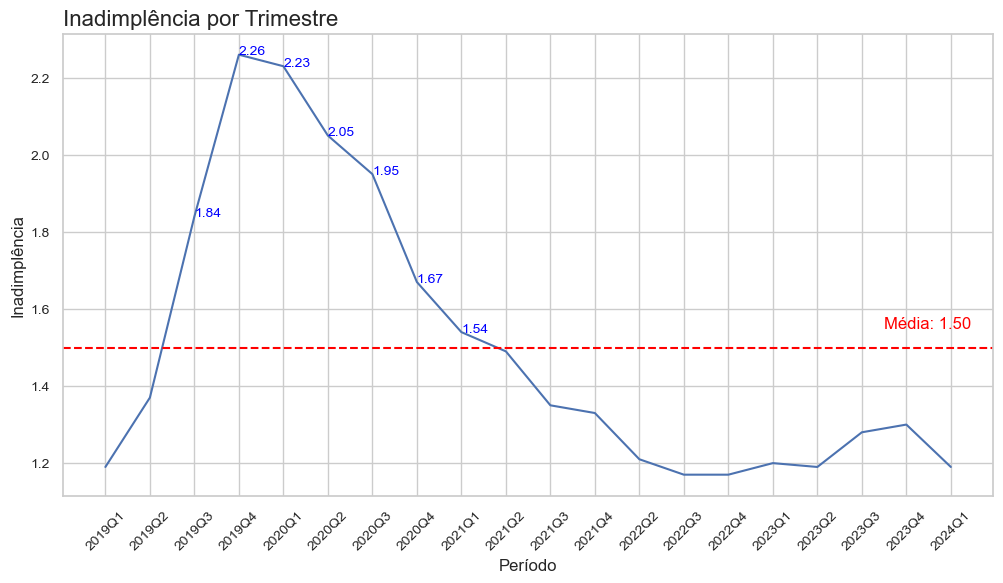

In [13]:
# Analisando o Resultado graficamente

# Configurando o stilo do Seaborn
sns.set(style="whitegrid")

# Criando o Gráfico base
plt.figure(figsize=(12,6))
ax = sns.lineplot(x='PERIODICITY', y='PER_DEFAULT', data=v_final)

# Adicionando Títulos e Legendas
plt.title('Inadimplência por Trimestre', fontsize=16, loc='left')
plt.xlabel('Período', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.ylabel('Inadimplência', fontsize=12)
plt.yticks(fontsize=10)

# Criando uma linha com a média de Inadimplência
media_line = v_final['PER_DEFAULT'].mean()
ax.axhline(media_line, color='red', linestyle='--')
ax.text(x=17.5, y= (media_line+0.05), s=f'Média: {media_line:.2f}', color='red')

# Anotações
for x, y in zip(v_final['PERIODICITY'], v_final['PER_DEFAULT']):
    if y >= v_final['PER_DEFAULT'].mean():
        plt.text(x, y, f'{y}', color='blue', fontsize=10)

# Mostrar o gráfico
plt.show()

Podermos observar que o período entre o segundo trimestre de 2022 até o primeiro trimestre de 2024 (Janeiro - Data Atual deste Projeto) é um período mais estável de inadimplência e será nosso foco de trabalho para construção da variável resposta. Desta forma trabalharemos com ever30mob22, sendo considerado MAU PAGADOR (0) clientes com mais de 30 dias de atraso em uma janela de 22 meses. De forma oposta, BOM PAGADOR (1) sem inadimplência no mesmo período.

In [14]:
# Copiando a Base de dados para Filtragem da Janela de Referência
dpd = dpd_data.copy()

In [15]:
# Filtrando a base de dados dpd para a janela de 29 meses
dpd = dpd[dpd['MONTHS_BALANCE'] >= -22]

# Deletando coluna Months_Balance
dpd.drop('MONTHS_BALANCE', axis=1, inplace=True)

# Alterando o Tipo de Dado da Coluna STATUS
dpd['STATUS_D'] = dpd['STATUS'].map(classifier)

# Deletando a Variável Original Status
dpd.drop('STATUS', axis=1, inplace=True)
# Visualizando o resultado
dpd.head()

,ID,STATUS_D
0,5001711,BOM PAGADOR
1,5001711,BOM PAGADOR
2,5001711,BOM PAGADOR
3,5001711,BOM PAGADOR
4,5001712,BOM PAGADOR


In [16]:
# Visualizando o Balanceamento do dataset quanto as classes de Bom Pagador e Mau Pagador
dpd['STATUS_D'].value_counts()

STATUS_D
BOM PAGADOR    655034
MAU PAGADOR      8096
Name: count, dtype: int64

In [17]:
# Unificando os Datasets em um único de trabalho
dataset = pd.merge(left=client_data, right=dpd, on="ID")
dataset.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,STATUS_D
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,BOM PAGADOR
1,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,BOM PAGADOR
2,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,BOM PAGADOR
3,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,BOM PAGADOR
4,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,BOM PAGADOR


In [18]:
# Checando Missing Data
dataset.isna().sum()

ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        148779
CNT_FAM_MEMBERS             0
STATUS_D                    0
dtype: int64

Como efetuamos um filtro nos ID's até 22 meses, teremos alguns Clientes que devem ser retirados da base de dados Client_Data. 

In [19]:
# Eliminando os dados missing
dataset.dropna(inplace=True)
dataset.isna().sum()

ID                     0
CODE_GENDER            0
FLAG_OWN_CAR           0
FLAG_OWN_REALTY        0
CNT_CHILDREN           0
AMT_INCOME_TOTAL       0
NAME_INCOME_TYPE       0
NAME_EDUCATION_TYPE    0
NAME_FAMILY_STATUS     0
NAME_HOUSING_TYPE      0
DAYS_BIRTH             0
DAYS_EMPLOYED          0
FLAG_MOBIL             0
FLAG_WORK_PHONE        0
FLAG_PHONE             0
FLAG_EMAIL             0
OCCUPATION_TYPE        0
CNT_FAM_MEMBERS        0
STATUS_D               0
dtype: int64

In [20]:
# Verificando o Balanceamento do Dataset
dataset['STATUS_D'].value_counts()

STATUS_D
BOM PAGADOR    332563
MAU PAGADOR      4820
Name: count, dtype: int64

Temos então um dataset desbalanceado, o que é normal para o problema de negócio, visto que temos mais adimplentes que inadimplentes em uma instituição financeira. No nosso caso, temos 1,45% de maus pagadores e 98,55% de bons pagadores. Podemos aplicar algumas regras para trabalhar essa informação, porém a priori, vamos analisar o padrão dos dados e compreender como os clientes se comportam em relação as variáveis. Voltaremos neste assunto durante o pré-processamento.

### Estudo dos Dados e Identificação de Padrões de Comportamento dos Tomadores de Crédito

Para esta etapa, vamos analisar inicialmente cada uma das variáveis em relação a Variável Resposta, com o objetivo de identificar oportunidades e caracterizar o cliente inadimplente.
Vamos começar com as Variáveis Categóricas, analisando frequência e proporcionalidade.

#### Gênero

In [21]:
# Criando um subset dos dados
gen = dataset[['CODE_GENDER', 'STATUS_D']]
gen.head()

,CODE_GENDER,STATUS_D
31,M,BOM PAGADOR
32,M,BOM PAGADOR
33,M,BOM PAGADOR
34,M,BOM PAGADOR
35,M,BOM PAGADOR


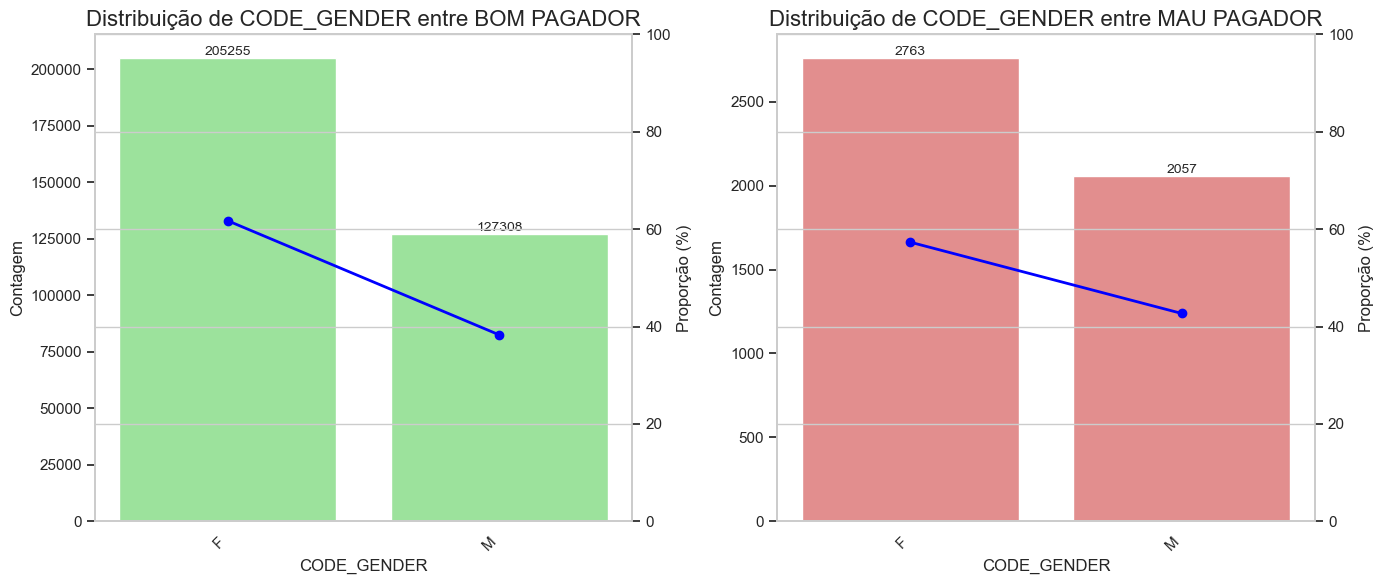

In [22]:
# Visualizando as Categorias por Inadimplêcnia
comp_cat(dataset=gen, independente='CODE_GENDER', resposta='STATUS_D')


In [23]:
# Desenhando uma Tabela Cruzada Referenciando a Inadimplência
tabela_cruzada1 = pd.crosstab(gen['STATUS_D'], gen['CODE_GENDER'], normalize='index', margins=True )

# Desenhando a Tabela Cruzada referenciando o Gênero
tabela_cruzada2 = pd.crosstab(gen['CODE_GENDER'], gen['STATUS_D'], normalize='index', margins=True )
print(f'Tabela Cruzada 1 \n{tabela_cruzada1}\n\nTabela Cruzada 2\n{tabela_cruzada2}')

Tabela Cruzada 1 
CODE_GENDER         F         M
STATUS_D                       
BOM PAGADOR  0.617191  0.382809
MAU PAGADOR  0.573237  0.426763
All          0.616563  0.383437

Tabela Cruzada 2
STATUS_D     BOM PAGADOR  MAU PAGADOR
CODE_GENDER                          
F               0.986717     0.013283
M               0.984099     0.015901
All             0.985714     0.014286


A pergunta que podemos fazer: "Mulheres são piores pagadores que os Homens, para este conjunto de dados?"

Vamos estudar o Raciocínio por traz da Probabilidade:
- *Proporção Maior Não Significa Maior Probabilidade*: O fato de haver uma proporção maior de mulheres no grupo de maus pagadores, em comparação com a sua proporção na amostra total, não significa necessariamente que as mulheres tem maior probabilidade de serem más pagadoras. Isso ocorre porque a proporção de mulheres na amostra total também é maior.
- *Análise de Risco Relativo*: Para fazer uma afirmação sobre o risco relativo de mulheres serem más pagadoras em comparação com os homens, será necessário calcular as taxas de inadimplência separadamente para homens e mulheres. Ou seja, qual porcentagem das mulheres é de maus pagadores e qual porcetagem dos homens é de maus pagadores.
- *Conclusão*: Portanto, para afirmar corretamente que gênero influencia a probabilidade de ser mau pagador, precisamos aplicar um teste estatístico e verificar se as diferenças das taxas de inadimplência são estatisticamente significativas. 

Para a natureza dos nossos dados, utilizaremos o teste Qui-Quadrado e o Teste de Proporções. O primeiro é útil para analisar associação entre variáveis categórias e funciona melhor com amostras maiores do que o teste de Fisher por exemplo. O segundo compara as proporções e nos retorna se as diferenças são significativas.

In [24]:
# Teste do Qui-Quadrado
teste_qui(dataset=gen, independente='CODE_GENDER', resposta='STATUS_D')

Teste Qui-Quadrado

Hipóteses:
H0: Existe associação significativa entre as categorias da variável CODE_GENDER em termos de inadimplência.
H1: Não Existe associação significativa entre as categorias da variável CODE_GENDER em termos de inadimplência.

A Estatística p_value = 5.091691443581342e-10, portanto não rejeitamos H0. Existe associação significativa entre as categorias da variável CODE_GENDER em termos de inadimplência.


In [25]:
# Teste de Proporção
teste_prop(dataset=gen, independente='CODE_GENDER', resposta='STATUS_D')

Teste de Proporção

Hipóteses:
H0: Existe diferença significativa nas proporções entre as categorias da variável CODE_GENDER em termos de inadimplência.
H1: Não Existe diferença significativa nas proporções entre as categorias da variável CODE_GENDER em termos de inadimplência.

A Estatística p_value = 0.0000, portanto não rejeitamos H0. Existe diferença significativa nas proporções entre as categorias da variável CODE_GENDER em termos de inadimplência.


Conforme vimos o resultado dos testes de hipóteses aplicados, podemos afirmar que os Homens são mais inadimplentes que as Mulheres, visto que as diferenças de suas proporções da Classe Mau Pagador, são estatisticamente significativas.

#### Propriedade Veicular

De forma análoga ao Gênero, vamos analisar como a variável de propriedade veicular está relacionada com a Variável Resposta.

In [26]:
# Criando um novo Subset
foc = dataset[['FLAG_OWN_CAR', 'STATUS_D']]
foc.head()

,FLAG_OWN_CAR,STATUS_D
31,Y,BOM PAGADOR
32,Y,BOM PAGADOR
33,Y,BOM PAGADOR
34,Y,BOM PAGADOR
35,Y,BOM PAGADOR


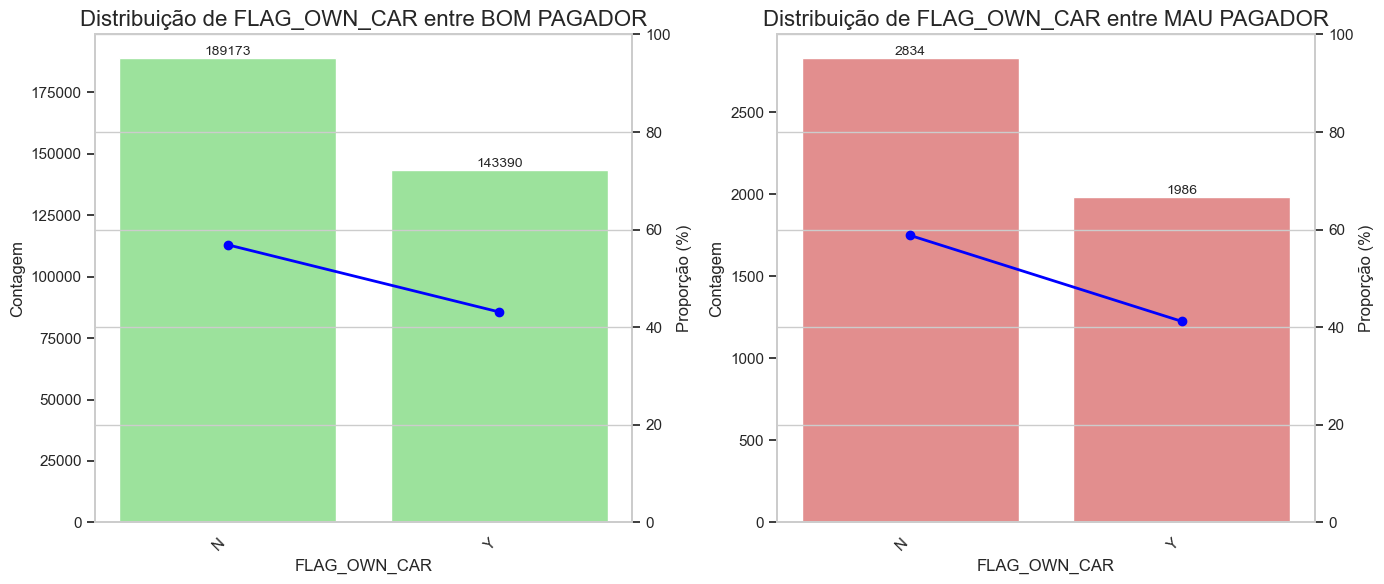

In [27]:
# Visualizando as Categorias por Inadimplência
comp_cat(dataset=foc, independente='FLAG_OWN_CAR', resposta='STATUS_D')


In [28]:
# Desenhando uma Tabela Cruzada Referenciando a Inadimplência
tabela_cruzada1 = pd.crosstab(foc['STATUS_D'], foc['FLAG_OWN_CAR'], normalize='index', margins=True )

# Desenhando a Tabela Cruzada referenciando a Propriedade Veicular
tabela_cruzada2 = pd.crosstab(foc['FLAG_OWN_CAR'], foc['STATUS_D'], normalize='index', margins=True )
print(f'Tabela Cruzada Inadimplência \n{tabela_cruzada1}\n\nTabela Cruzada Propriedade Veicular\n{tabela_cruzada2}')

Tabela Cruzada Inadimplência 
FLAG_OWN_CAR         N         Y
STATUS_D                        
BOM PAGADOR   0.568834  0.431166
MAU PAGADOR   0.587967  0.412033
All           0.569107  0.430893

Tabela Cruzada Propriedade Veicular
STATUS_D      BOM PAGADOR  MAU PAGADOR
FLAG_OWN_CAR                          
N                0.985240     0.014760
Y                0.986339     0.013661
All              0.985714     0.014286


A pergunta que podemos fazer: "Proprietários de Veículos são melhores pagores que aqueles que não possuem veículos, para este conjunto de dados?"

Vamos seguir o mesmo raciocío sobre proporcionalidade que construimo para o Gênero, utilizando o teste Qui-Quadrado e o Teste de Proporções. 

In [29]:
# Teste do Qui-Quadrado
teste_qui(dataset=foc, independente='FLAG_OWN_CAR', resposta='STATUS_D')

Teste Qui-Quadrado

Hipóteses:
H0: Existe associação significativa entre as categorias da variável FLAG_OWN_CAR em termos de inadimplência.
H1: Não Existe associação significativa entre as categorias da variável FLAG_OWN_CAR em termos de inadimplência.

A Estatística p_value = 0.00808349843734669, portanto não rejeitamos H0. Existe associação significativa entre as categorias da variável FLAG_OWN_CAR em termos de inadimplência.


In [30]:
# Teste de Proporção
teste_prop(dataset=foc, independente='FLAG_OWN_CAR', resposta='STATUS_D')

Teste de Proporção

Hipóteses:
H0: Existe diferença significativa nas proporções entre as categorias da variável FLAG_OWN_CAR em termos de inadimplência.
H1: Não Existe diferença significativa nas proporções entre as categorias da variável FLAG_OWN_CAR em termos de inadimplência.

A Estatística p_value = 0.0077, portanto não rejeitamos H0. Existe diferença significativa nas proporções entre as categorias da variável FLAG_OWN_CAR em termos de inadimplência.


Conforme vimos o resultado dos testes de hipóteses aplicados, podemos afirmar que os não Proprietários de Veículos são mais inadimplentes que proprietários de veículos, visto que as diferenças de suas proporções da Classe Mau Pagador, são estatisticamente significativas.

##### Propriedade Residencial

De forma análoga as variáveis categóricas anteriores, vamos analisar como a variável de propriedade residencial está relacionada com a Variável Resposta.

In [31]:
# Criando um novo Subset
fores = dataset[['FLAG_OWN_REALTY', 'STATUS_D']]
fores.head()

,FLAG_OWN_REALTY,STATUS_D
31,Y,BOM PAGADOR
32,Y,BOM PAGADOR
33,Y,BOM PAGADOR
34,Y,BOM PAGADOR
35,Y,BOM PAGADOR


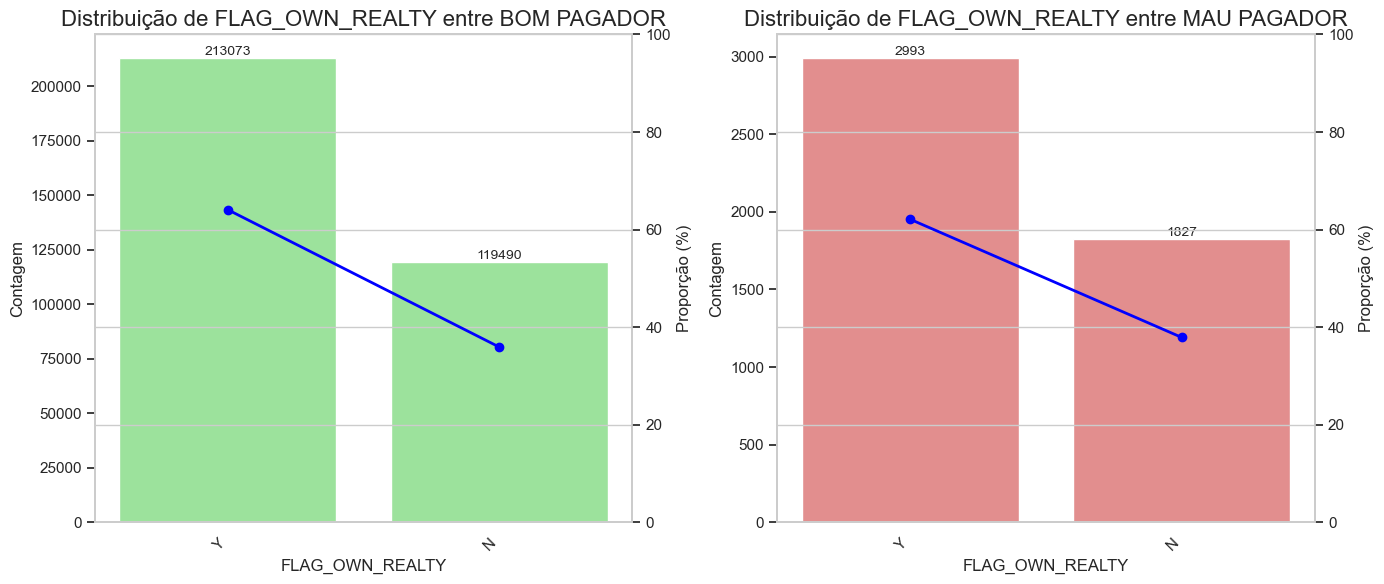

In [32]:
# Visualizando as Categorias por Inadimplência
comp_cat(dataset=fores, independente='FLAG_OWN_REALTY', resposta='STATUS_D')

In [33]:
# Desenhando uma Tabela Cruzada Referenciando a Inadimplência
tabela_cruzada1 = pd.crosstab(fores['STATUS_D'], fores['FLAG_OWN_REALTY'], normalize='index', margins=True )

# Desenhando a Tabela Cruzada referenciando a Propriedade Residencial
tabela_cruzada2 = pd.crosstab(fores['FLAG_OWN_REALTY'], fores['STATUS_D'], normalize='index', margins=True )
print(f'Tabela Cruzada Inadimplência \n{tabela_cruzada1}\n\nTabela Cruzada Residência Própria\n{tabela_cruzada2}')

Tabela Cruzada Inadimplência 
FLAG_OWN_REALTY         N         Y
STATUS_D                           
BOM PAGADOR      0.359300  0.640700
MAU PAGADOR      0.379046  0.620954
All              0.359582  0.640418

Tabela Cruzada Residência Própria
STATUS_D         BOM PAGADOR  MAU PAGADOR
FLAG_OWN_REALTY                          
N                   0.984940     0.015060
Y                   0.986148     0.013852
All                 0.985714     0.014286


A pergunta que podemos fazer: "Clientes com Residência Própria são melhores pagores que aqueles que não possuem Residência Própria, para este conjunto de dados?"

Vamos aplicar os testes Qui-Quadrado e de Proporção para podermos averiguar essa hipótese.

In [34]:
# Teste do Qui-Quadrado
teste_qui(dataset=fores, independente='FLAG_OWN_REALTY', resposta='STATUS_D')

Teste Qui-Quadrado

Hipóteses:
H0: Existe associação significativa entre as categorias da variável FLAG_OWN_REALTY em termos de inadimplência.
H1: Não Existe associação significativa entre as categorias da variável FLAG_OWN_REALTY em termos de inadimplência.

A Estatística p_value = 0.0047866636454567, portanto não rejeitamos H0. Existe associação significativa entre as categorias da variável FLAG_OWN_REALTY em termos de inadimplência.


In [35]:
# Teste de Proporção
teste_prop(dataset=fores, independente='FLAG_OWN_REALTY', resposta='STATUS_D')

Teste de Proporção

Hipóteses:
H0: Existe diferença significativa nas proporções entre as categorias da variável FLAG_OWN_REALTY em termos de inadimplência.
H1: Não Existe diferença significativa nas proporções entre as categorias da variável FLAG_OWN_REALTY em termos de inadimplência.

A Estatística p_value = 0.0046, portanto não rejeitamos H0. Existe diferença significativa nas proporções entre as categorias da variável FLAG_OWN_REALTY em termos de inadimplência.


Conforme vimos o resultado dos testes de hipóteses aplicados, podemos afirmar que os Clientes com Residência Própria são menos inadimplentes que clientes que não possuem residência própria, visto que as diferenças de suas proporções da Classe Mau Pagador, são estatisticamente significativas.

#### Número de Filhos

Vamos analisar primeiramente as estatísticas de posição e dispersão da variável Filhos.

In [36]:
# Criando um subset
cchild = dataset[['CNT_CHILDREN', 'STATUS_D']]
cchild.groupby(cchild['STATUS_D']).value_counts()

STATUS_D     CNT_CHILDREN
BOM PAGADOR  0               211708
             1                79639
             2                36143
             3                 4098
             4                  730
             5                  163
             14                  50
             7                   26
             19                   6
MAU PAGADOR  0                 3143
             1                 1163
             2                  447
             3                   49
             4                    7
             7                    7
             14                   4
Name: count, dtype: int64

In [37]:
# Estatísticas de Posição e Dispersão
cchild.describe()

,CNT_CHILDREN
count,337383.000000
mean,0.507693
std,0.784725
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,19.000000


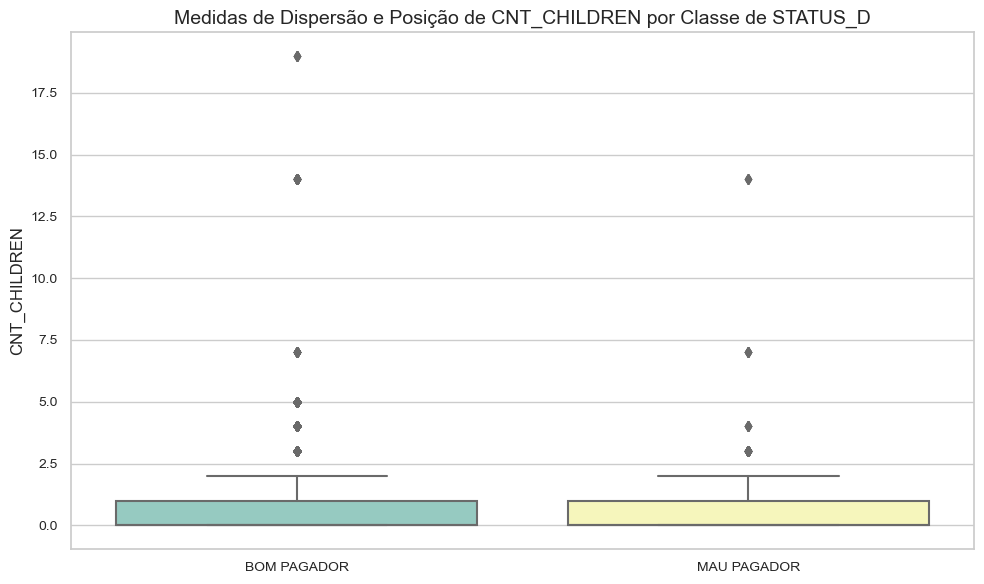

In [38]:
# Visualizando Graficamente
box_graf(dataset=cchild, independente='CNT_CHILDREN', resposta='STATUS_D')

Podemos observar que temos outliers em nosso dataset, portanto vamos utilizar a técnica de Quartis, excluindo esse dados e refazendo as estatísticas de posição e dispersão.

In [39]:
# Removendo os Outliers
cchild = elimina_outliers(dataset=cchild, independente='CNT_CHILDREN')

# Estatísticas de Posição e Dispersão
cchild.describe()

,CNT_CHILDREN
count,332243.000000
mean,0.463462
std,0.684782
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,2.000000


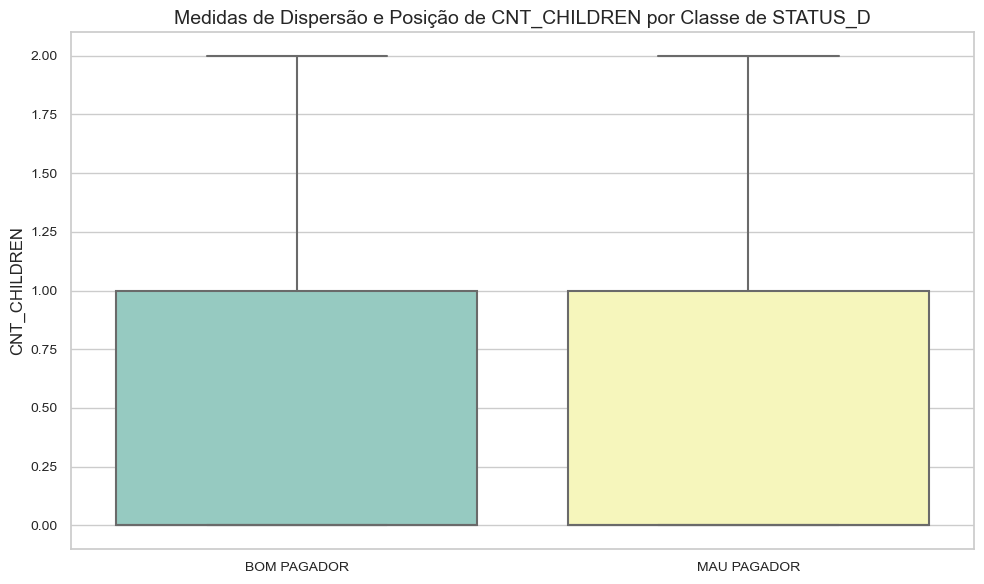

In [40]:
# Visualizando Graficamente
box_graf(dataset=cchild, independente='CNT_CHILDREN', resposta='STATUS_D')

Podemos verificar que a média de filhos é 0.45, porém não é realista. Vamos considerar que na média os clientes possuem 1 filho, considerando que o desvio padrão é de 0.68, e que metade da nossa amostra de clientes não possuem filhos (mediana = 0).

Vamos aplicar uma escala Likert e avaliar nossa variável como categórica. Assim poderemos analisar as associações e proporções em relação a variável inadimplência.


In [41]:
# Ajustando a Variável Número de Filhos para Categórica com 3 Categorias

# Criando uma função classificadora
def categ_filhos(qtd_filhos):
    if qtd_filhos == 0:
        return 'Sem Filhos'
    elif 1 <= qtd_filhos <= 2:
        return 'De 1 a 2 Filhos'
    else:
        return 'Mais de 3 Filhos'
    
# Aplicando a Função no Dataset
cchild1 = cchild.copy()
cchild1['CHILDREN'] = cchild['CNT_CHILDREN'].apply(categ_filhos)
cchild1.drop(labels='CNT_CHILDREN', axis=1, inplace=True)

# Visualizando a Categorização
cchild1.groupby(cchild1['STATUS_D']).value_counts()

STATUS_D     CHILDREN       
BOM PAGADOR  Sem Filhos         211708
             De 1 a 2 Filhos    115782
MAU PAGADOR  Sem Filhos           3143
             De 1 a 2 Filhos      1610
Name: count, dtype: int64

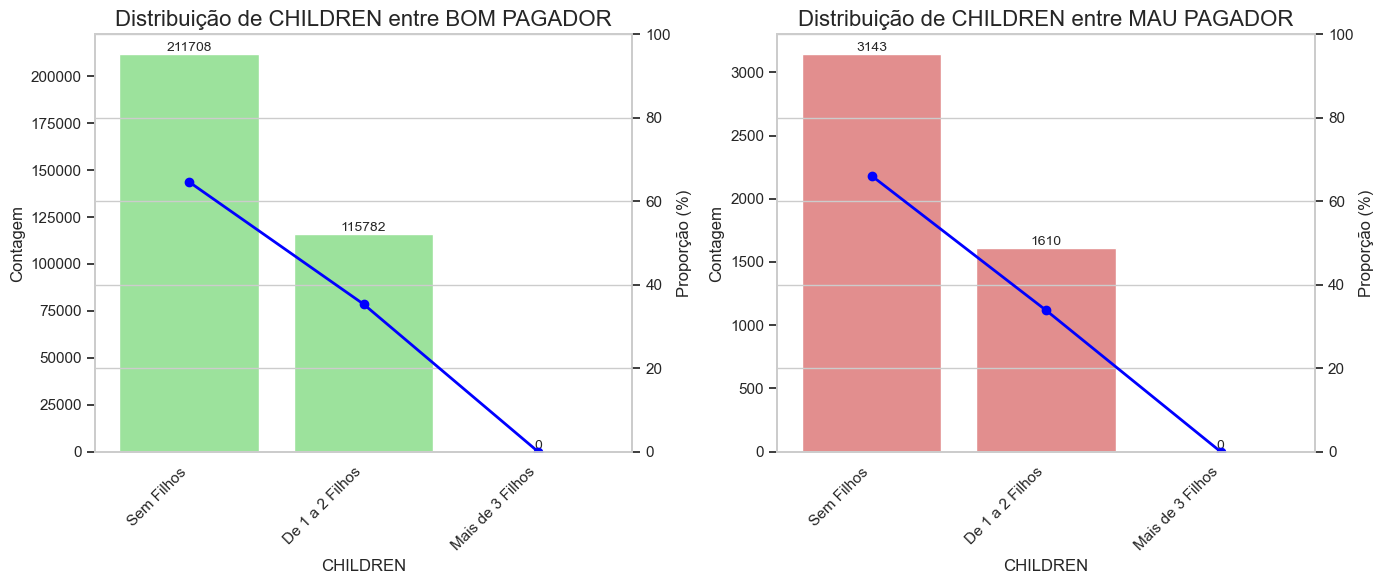

In [42]:
# Visualizando as Categorias por Inadimplência
comp_cat(dataset=cchild1, independente='CHILDREN', resposta='STATUS_D', ordem=['Sem Filhos', 'De 1 a 2 Filhos', 'Mais de 3 Filhos'])

In [43]:
# Desenhando uma Tabela Cruzada Referenciando a Inadimplência
tabela_cruzada1 = pd.crosstab(cchild1['STATUS_D'], cchild1['CHILDREN'], normalize='index', margins=True )

# Desenhando a Tabela Cruzada referenciando a Quantidade de Filhos
tabela_cruzada2 = pd.crosstab(cchild1['CHILDREN'], cchild1['STATUS_D'], normalize='index', margins=True )
print(f'Tabela Cruzada Inadimplência \n{tabela_cruzada1}\n\nTabela Cruzada Filhos\n{tabela_cruzada2}')

Tabela Cruzada Inadimplência 
CHILDREN     De 1 a 2 Filhos  Sem Filhos
STATUS_D                                
BOM PAGADOR         0.353544    0.646456
MAU PAGADOR         0.338733    0.661267
All                 0.353332    0.646668

Tabela Cruzada Filhos
STATUS_D         BOM PAGADOR  MAU PAGADOR
CHILDREN                                 
De 1 a 2 Filhos     0.986285     0.013715
Sem Filhos          0.985371     0.014629
All                 0.985694     0.014306


Suposições que podemos fazer:
 1. "Clientes Com Filhos são menos inadimplentes que clientes Sem Filhos."

Vamos verificar a suposição, primeiramente conferindo se há associação entre as variáveis resposta e independente (CHILDREN) e então se podemos comparar as proporções entre elas. 

In [44]:
# Ajustando a Variável para 2 Categorias
cchild2 = cchild.copy()

# Função de Categorização
def categ_filhos1(qtd_filhos):
    if qtd_filhos == 0:
        return 'Sem Filhos'
    else:
        return 'Com Filhos'
    
# Aplicando a Categorização na Variável CNT_CHILDREN
cchild2['CHILDREN'] = cchild2['CNT_CHILDREN'].apply(categ_filhos1)
cchild2.drop(labels='CNT_CHILDREN', axis=1, inplace=True)
cchild2['STATUS'] = cchild2['STATUS_D']
cchild2.drop(labels='STATUS_D', axis = 1, inplace=True)

# Visualizando a Categorização e as Proporções por Categoria
tabela_cruzada = pd.crosstab(cchild2['CHILDREN'], cchild2['STATUS'], normalize='index', margins=True )
print(f'Tabela Cruzada Inadimplência \n{tabela_cruzada}')

Tabela Cruzada Inadimplência 
STATUS      BOM PAGADOR  MAU PAGADOR
CHILDREN                            
Com Filhos     0.986285     0.013715
Sem Filhos     0.985371     0.014629
All            0.985694     0.014306


In [45]:
# Teste de Hipótese Qui-Quadrado
teste_qui(dataset=cchild2, independente='CHILDREN', resposta='STATUS')

Teste Qui-Quadrado

Hipóteses:
H0: Existe associação significativa entre as categorias da variável CHILDREN em termos de inadimplência.
H1: Não Existe associação significativa entre as categorias da variável CHILDREN em termos de inadimplência.

A Estatística p_value = 0.035253142924993736, portanto não rejeitamos H0. Existe associação significativa entre as categorias da variável CHILDREN em termos de inadimplência.


In [46]:
# Teste de Hipótese de Proporções
teste_prop(dataset=cchild2, independente='CHILDREN', resposta='STATUS')

Teste de Proporção

Hipóteses:
H0: Existe diferença significativa nas proporções entre as categorias da variável CHILDREN em termos de inadimplência.
H1: Não Existe diferença significativa nas proporções entre as categorias da variável CHILDREN em termos de inadimplência.

A Estatística p_value = 0.0339, portanto não rejeitamos H0. Existe diferença significativa nas proporções entre as categorias da variável CHILDREN em termos de inadimplência.


Desta forma, podemos afirmar que que os Clientes com Filhos são menos inadimplentes que clientes que não possuem filhos, visto que as diferenças de suas proporções da Classe Mau Pagador, são estatisticamente significativas.

#### Origem da Receita

Vamos analisar a Variável NAME_INCOME_TYPE, com relação as frequências e proporções.

In [47]:
# Criando um subset
nit = dataset[['NAME_INCOME_TYPE', 'STATUS_D']]
nit.groupby(nit['STATUS_D']).value_counts()

STATUS_D     NAME_INCOME_TYPE    
BOM PAGADOR  Working                 205903
             Commercial associate     94335
             State servant            31932
             Pensioner                  205
             Student                    188
MAU PAGADOR  Working                   2819
             Commercial associate      1507
             State servant              445
             Pensioner                   49
Name: count, dtype: int64

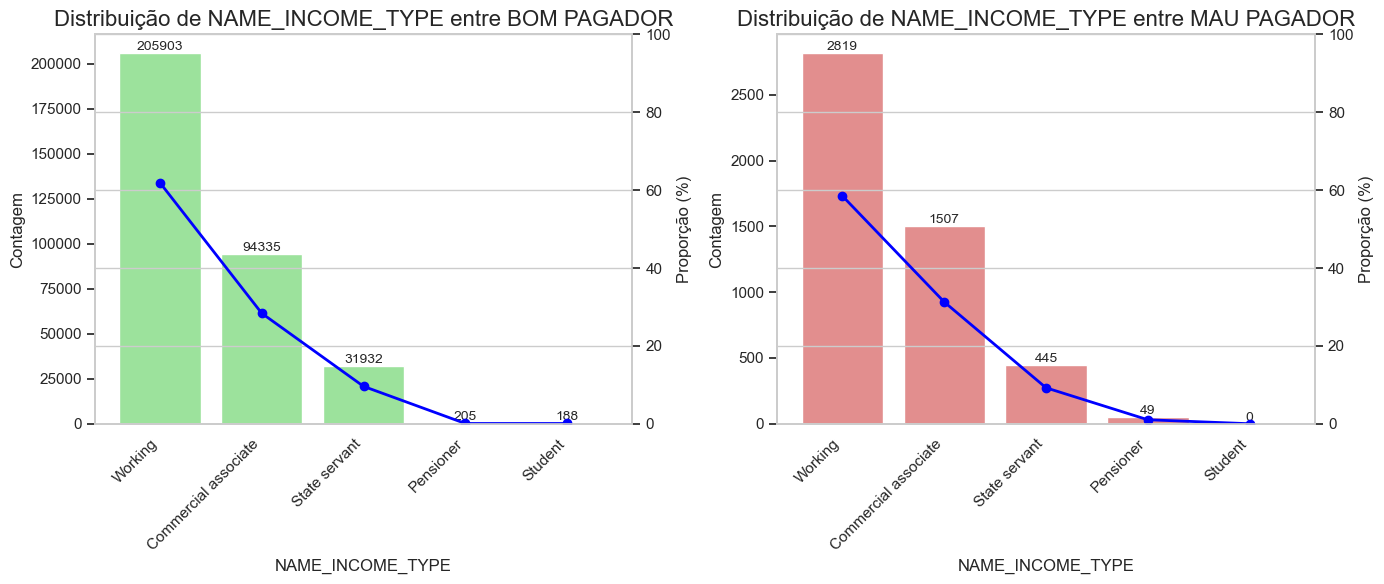

In [48]:
# Visualizando as Categorias por Inadimplência
comp_cat(dataset=nit, independente='NAME_INCOME_TYPE', resposta='STATUS_D')

In [142]:
# Desenhando uma Tabela Cruzada Referenciando a Inadimplência
tabela_cruzada1 = pd.crosstab(nit['STATUS_D'], nit['NAME_INCOME_TYPE'], normalize='index', margins=True )

# Desenhando a Tabela Cruzada referenciando a Origem da Receita
tabela_cruzada2 = pd.crosstab(nit['NAME_INCOME_TYPE'], nit['STATUS_D'], normalize='index', margins=True )
print(f'Tabela Cruzada Inadimplência \n{tabela_cruzada1}\n\nTabela Cruzada Origem das Receitas\n{tabela_cruzada2}')

Tabela Cruzada Inadimplência 
NAME_INCOME_TYPE  Commercial associate  Pensioner  State servant   Student  \
STATUS_D                                                                     
BOM PAGADOR                   0.283661   0.000616       0.096018  0.000565   
MAU PAGADOR                   0.312656   0.010166       0.092324  0.000000   
All                           0.284075   0.000753       0.095965  0.000557   

NAME_INCOME_TYPE   Working  
STATUS_D                    
BOM PAGADOR       0.619140  
MAU PAGADOR       0.584855  
All               0.618650  

Tabela Cruzada Origem das Receitas
STATUS_D              BOM PAGADOR  MAU PAGADOR
NAME_INCOME_TYPE                              
Commercial associate     0.984276     0.015724
Pensioner                0.807087     0.192913
State servant            0.986256     0.013744
Student                  1.000000     0.000000
Working                  0.986494     0.013506
All                      0.985714     0.014286


Alguns fatos são curiosos em relação as proporções das categorias de origem de receita. Podemos relacionar:
- Estudantes são 100% 'BONS PAGADORES'
- Pensionistas são os Piores Clientes em relação a Inadimplência, com uma proporção de 19.29% de MAUS PAGADORES.
- Clientes do Setor Privado, em comparação ao Setor Público, parecem ser melhores pagadores. 

Faremos um teste de hipótese para verficar se existe associação entre as variáveis e outro teste para analisar se podemos realizar comparações entre as proporções.

In [143]:
# Teste de Hipótese Qui-Quadrado
teste_qui(dataset=nit, independente='NAME_INCOME_TYPE', resposta='STATUS_D')

Teste Qui-Quadrado

Hipóteses:
H0: Existe associação significativa entre as categorias da variável NAME_INCOME_TYPE em termos de inadimplência.
H1: Não Existe associação significativa entre as categorias da variável NAME_INCOME_TYPE em termos de inadimplência.

A Estatística p_value = 5.7222886728624665e-129, portanto não rejeitamos H0. Existe associação significativa entre as categorias da variável NAME_INCOME_TYPE em termos de inadimplência.


In [144]:
# Teste de Hipótese de Proporções
test_anova_1_via(crosstab=tabela_cruzada2, independente='NAME_INCOME_TYPE', resposta='STATUS_D')

Resultado do Teste ANOVA de 1 Via:
-----------------------------------
Estatística F: 7.606717263953238
Valor p: 0.024750053316413903
Há evidências suficientes para concluir que a proporção de inadimplência é diferente entre as categorias de NAME_INCOME_TYPE_1 (p-valor < 0.05).


Como podemos observar nos resultados, podemos afirmar que Clientes com renda no Setor Público são piores pagadores que os Clientes com renda do Setor Privado. Assim como que Pensionistas são mais inadimplentes do que clientes com outras fontes de renda.

#### Formação Acadêmica

Vamos analisar como o nível de formação acadêmica dos clientes (NAME_EDUCATION_TYPE) se distribui entre as categorias de MAU PAGADOR e BOM PAGADOR.

In [53]:
# Criando um subset
net = dataset[['NAME_EDUCATION_TYPE', 'STATUS_D']]
net.groupby(net['STATUS_D']).value_counts()

STATUS_D     NAME_EDUCATION_TYPE          
BOM PAGADOR  Secondary / secondary special    221429
             Higher education                  95237
             Incomplete higher                 12859
             Lower secondary                    2753
             Academic degree                     285
MAU PAGADOR  Secondary / secondary special      3163
             Higher education                   1353
             Incomplete higher                   261
             Lower secondary                      43
Name: count, dtype: int64

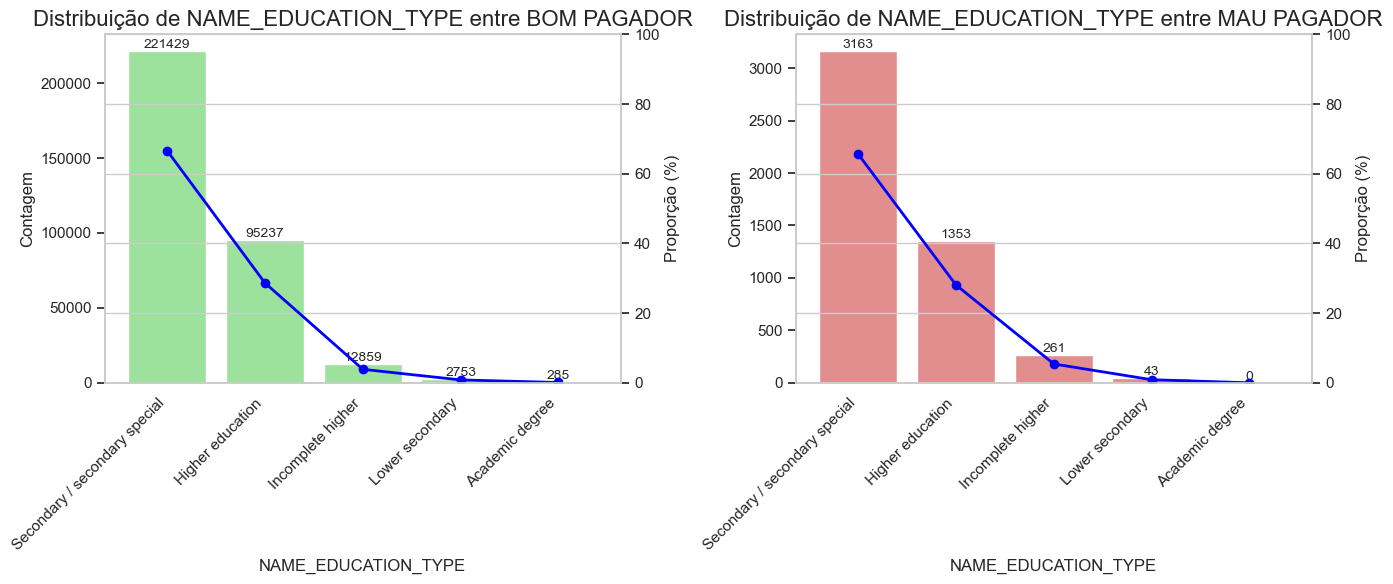

In [54]:
# Visualizando as Categorias por Inadimplência
comp_cat(dataset=net, independente='NAME_EDUCATION_TYPE', resposta='STATUS_D')

In [145]:
# Desenhando uma Tabela Cruzada Referenciando a Inadimplência
tabela_cruzada1 = pd.crosstab(net['STATUS_D'], net['NAME_EDUCATION_TYPE'], normalize='index', margins=True )

# Desenhando a Tabela Cruzada referenciando o Nível de Educação dos Clientes
tabela_cruzada2 = pd.crosstab(net['NAME_EDUCATION_TYPE'], net['STATUS_D'], normalize='index', margins=True )
print(f'Tabela Cruzada Inadimplência \n{tabela_cruzada1}\n\nTabela Cruzada Educação dos Clientes\n{tabela_cruzada2}')

Tabela Cruzada Inadimplência 
NAME_EDUCATION_TYPE  Academic degree  Higher education  Incomplete higher  \
STATUS_D                                                                    
BOM PAGADOR                 0.000857          0.286373           0.038666   
MAU PAGADOR                 0.000000          0.280705           0.054149   
All                         0.000845          0.286292           0.038888   

NAME_EDUCATION_TYPE  Lower secondary  Secondary / secondary special  
STATUS_D                                                             
BOM PAGADOR                 0.008278                       0.665826  
MAU PAGADOR                 0.008921                       0.656224  
All                         0.008287                       0.665689  

Tabela Cruzada Educação dos Clientes
STATUS_D                       BOM PAGADOR  MAU PAGADOR
NAME_EDUCATION_TYPE                                    
Academic degree                   1.000000     0.000000
Higher education            

Algumas suposições que podemos fazer para o comparativo das categorias na Classe MAU PAGADOR:
- Clientes em Formação Acedêmica são 100% bons pagadores.
- Clientes com Ensino Médio Incompleto são mais inadimplentes que clientes com demais formações educacionais.

 Vamos verificar por meio de um teste de hipótese se podemos associar as variáveis e se podemos comparar as proporções entre as classes.

In [147]:
# Teste de Hipótese Qui-Quadrado
teste_qui(dataset=net, independente='NAME_EDUCATION_TYPE', resposta='STATUS_D')

Teste Qui-Quadrado

Hipóteses:
H0: Existe associação significativa entre as categorias da variável NAME_EDUCATION_TYPE em termos de inadimplência.
H1: Não Existe associação significativa entre as categorias da variável NAME_EDUCATION_TYPE em termos de inadimplência.

A Estatística p_value = 4.993176388201781e-07, portanto não rejeitamos H0. Existe associação significativa entre as categorias da variável NAME_EDUCATION_TYPE em termos de inadimplência.


In [150]:
# Teste de Hipótese de Proporção
test_anova_1_via(crosstab=tabela_cruzada2, independente='NAME_EDUCATION_TYPE', resposta='STATUS_D')

Resultado do Teste ANOVA de 1 Via:
-----------------------------------
Estatística F: 7.898762982768622
Valor p: 0.02282639102609247
Há evidências suficientes para concluir que a proporção de inadimplência é diferente entre as categorias de NAME_EDUCATION_TYPE_1 (p-valor < 0.05).


Como podemos verificar, é correto afirmar que:
- Clientes em Formação Acedêmica são 100% bons pagadores.
- Clientes com Ensino Médio Incompleto são mais inadimplentes que clientes com demais formações educacionais.

#### Estado Civil

O Estado Civil é representado pela Variável NAME_FAMILY_STATUS. Vamos analisar as frequências e as proporções.

In [62]:
# Criando um subset
nfs = dataset[['NAME_FAMILY_STATUS', 'STATUS_D']]
nfs.groupby(nfs['STATUS_D']).value_counts()

STATUS_D     NAME_FAMILY_STATUS  
BOM PAGADOR  Married                 235851
             Single / not married     42714
             Civil marriage           27340
             Separated                19272
             Widow                     7386
MAU PAGADOR  Married                   3238
             Single / not married       873
             Civil marriage             332
             Separated                  252
             Widow                      125
Name: count, dtype: int64

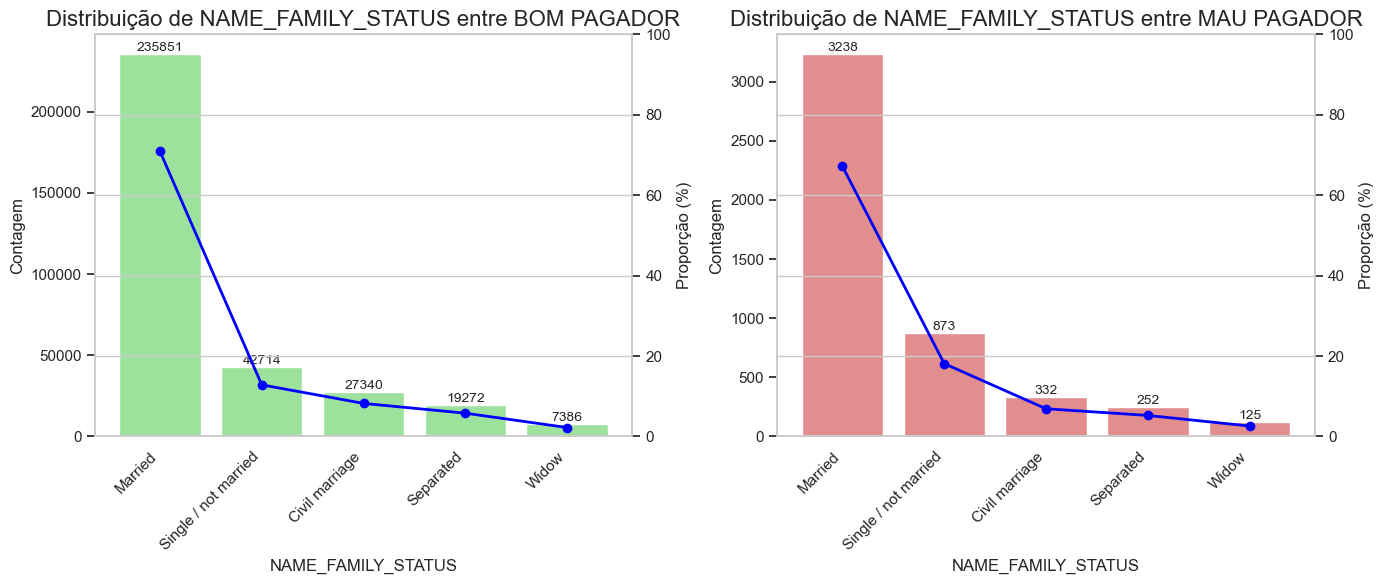

In [63]:
# Visualizando graficamente a Inadimplência por Estado civil
comp_cat(dataset=nfs, independente='NAME_FAMILY_STATUS', resposta='STATUS_D')

In [152]:
# Desenhando uma Tabela Cruzada Referenciando a Inadimplência
tabela_cruzada1 = pd.crosstab(nfs['STATUS_D'], nfs['NAME_FAMILY_STATUS'], normalize='index', margins=True )

# Desenhando a Tabela Cruzada referenciando o Estado Civil dos Clientes
tabela_cruzada2 = pd.crosstab(nfs['NAME_FAMILY_STATUS'], nfs['STATUS_D'], normalize='index', margins=True )
print(f'Tabela Cruzada Inadimplência \n{tabela_cruzada1}\n\nTabela Cruzada Estado Civil dos Clientes\n{tabela_cruzada2}')

Tabela Cruzada Inadimplência 
NAME_FAMILY_STATUS  Civil marriage   Married  Separated  Single / not married  \
STATUS_D                                                                        
BOM PAGADOR                0.08221  0.709192   0.057950              0.128439   
MAU PAGADOR                0.06888  0.671784   0.052282              0.181120   
All                        0.08202  0.708658   0.057869              0.129191   

NAME_FAMILY_STATUS     Widow  
STATUS_D                      
BOM PAGADOR         0.022209  
MAU PAGADOR         0.025934  
All                 0.022263  

Tabela Cruzada Estado Civil dos Clientes
STATUS_D              BOM PAGADOR  MAU PAGADOR
NAME_FAMILY_STATUS                            
Civil marriage           0.988002     0.011998
Married                  0.986457     0.013543
Separated                0.987093     0.012907
Single / not married     0.979971     0.020029
Widow                    0.983358     0.016642
All                      0.985714     

Algumas considerações que podemos fazer para o comparativo das categorias na Classe MAU PAGADOR:
- Clientes Casados (Civil marriage) aparentemente possuem a menor inadimplência em relação aos demais.
- Clientes Solteiros (Single / not marriage) aparentemente possuem a maior inadimplência em relação aos demais.

Vamos checar essas afirmações em relação as categorias subsequentes e validar a significância estatística.

In [153]:
# Teste de Associação Qui-Quadrado
teste_qui(dataset=nfs, independente='NAME_FAMILY_STATUS', resposta='STATUS_D')

Teste Qui-Quadrado

Hipóteses:
H0: Existe associação significativa entre as categorias da variável NAME_FAMILY_STATUS em termos de inadimplência.
H1: Não Existe associação significativa entre as categorias da variável NAME_FAMILY_STATUS em termos de inadimplência.

A Estatística p_value = 1.4437109027422033e-26, portanto não rejeitamos H0. Existe associação significativa entre as categorias da variável NAME_FAMILY_STATUS em termos de inadimplência.


In [154]:
# Teste de Proporção
test_anova_1_via(crosstab=tabela_cruzada2, independente='NAME_FAMILY_STATUS', resposta='STATUS_D')

Resultado do Teste ANOVA de 1 Via:
-----------------------------------
Estatística F: 7.8802265624361505
Valor p: 0.022942745957942177
Há evidências suficientes para concluir que a proporção de inadimplência é diferente entre as categorias de NAME_FAMILY_STATUS_1 (p-valor < 0.05).


Sendo assim, podemos afirmar que Clientes Casados possuem menor inadimplência entre as Categorias de Estado Civil e que Clientes Solteiros possuem maior inadimplência entre as Categorias de Estado Civil.

#### Tipo de Moradia

Vamos analisar o Tipo de Moradia e como se comporta em relação a Inadimplência.

In [67]:
# Construindo um Subset do Dataset
nht = dataset[['NAME_HOUSING_TYPE', 'STATUS_D']]
nht.groupby(nht['STATUS_D']).value_counts()

STATUS_D     NAME_HOUSING_TYPE  
BOM PAGADOR  House / apartment      292620
             With parents            18626
             Municipal apartment     11095
             Rented apartment         5672
             Office apartment         2538
             Co-op apartment          2012
MAU PAGADOR  House / apartment        4192
             With parents              277
             Municipal apartment       171
             Rented apartment          101
             Office apartment           56
             Co-op apartment            23
Name: count, dtype: int64

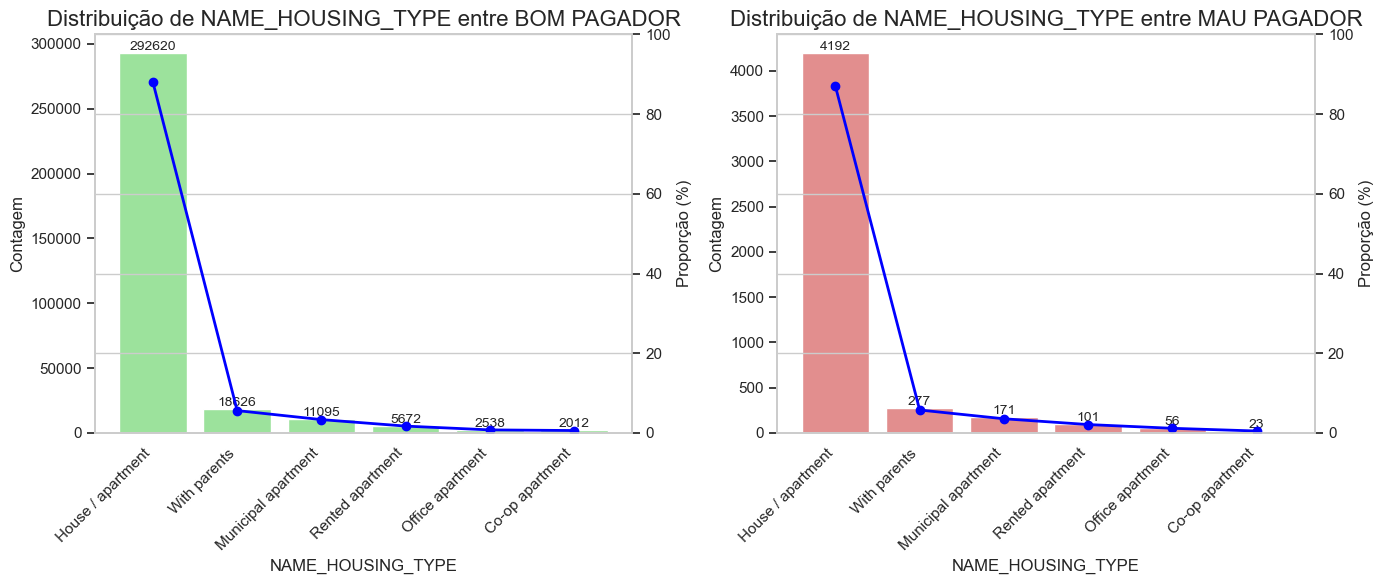

In [68]:
# Visualizando Graficamente as Categorias em relação a Inadimplência.
comp_cat(dataset=nht, independente='NAME_HOUSING_TYPE', resposta='STATUS_D')

In [69]:
# Desenhando uma Tabela Cruzada Referenciando a Inadimplência
tabela_cruzada1 = pd.crosstab(nht['STATUS_D'], nht['NAME_HOUSING_TYPE'], normalize='index', margins=True )

# Desenhando a Tabela Cruzada referenciando o Tipo de Moradia dos Clientes
tabela_cruzada2 = pd.crosstab(nht['NAME_HOUSING_TYPE'], nht['STATUS_D'], normalize='index', margins=True )
print(f'Tabela Cruzada Inadimplência \n{tabela_cruzada1}\n\nTabela Cruzada Tipo de Moradia dos Clientes\n{tabela_cruzada2}')

Tabela Cruzada Inadimplência 
NAME_HOUSING_TYPE  Co-op apartment  House / apartment  Municipal apartment  \
STATUS_D                                                                     
BOM PAGADOR               0.006050           0.879893             0.033362   
MAU PAGADOR               0.004772           0.869710             0.035477   
All                       0.006032           0.879748             0.033392   

NAME_HOUSING_TYPE  Office apartment  Rented apartment  With parents  
STATUS_D                                                             
BOM PAGADOR                0.007632          0.017055      0.056007  
MAU PAGADOR                0.011618          0.020954      0.057469  
All                        0.007689          0.017111      0.056028  

Tabela Cruzada Tipo de Moradia dos Clientes
STATUS_D             BOM PAGADOR  MAU PAGADOR
NAME_HOUSING_TYPE                            
Co-op apartment         0.988698     0.011302
House / apartment       0.985877     0.014123


Analisando as tabelas cruzadas podemos considerar:
- Clientes que dividem a Moradia (Co-op Apartment) aparentemente são os menos inadimplentes.
- Clientes que moram de Aluguel ou Funcional Privado, aparentemente são os mais inadimplentes.

Vamos confirmar as afirmações analisando se existe associação significativa e significância nas comparações das proporções.

In [70]:
# Teste de Associação Qui-Quadrado
teste_qui(dataset=nht, independente='NAME_HOUSING_TYPE', resposta='STATUS_D')

Teste Qui-Quadrado

Hipóteses:
H0: Existe associação significativa entre as categorias da variável NAME_HOUSING_TYPE em termos de inadimplência.
H1: Não Existe associação significativa entre as categorias da variável NAME_HOUSING_TYPE em termos de inadimplência.

A Estatística p_value = 0.005090901433456995, portanto não rejeitamos H0. Existe associação significativa entre as categorias da variável NAME_HOUSING_TYPE em termos de inadimplência.


In [71]:
# Teste de Proporção com ANOVA
test_anova_1_via(crosstab=tabela_cruzada2, independente='NAME_HOUSING_TYPE', resposta='STATUS_D')

Resultado do Teste ANOVA de 1 Via:
-----------------------------------
Estatística F: 10.57989929624821
Valor p: 0.008681082137766232
Há evidências suficientes para concluir que a proporção de inadimplência é diferente entre as categorias de NAME_HOUSING_TYPE_1 (p-valor < 0.05).


Portanto, podemos afirmar que as proporções são estatísticamente significativas e que Clientes que dividem apartamento são menos inadimplentes, assim como Clientes que moram de Aluguel ou Habitam Residência Funcional são mais inadimplentes.

#### Idade

Iniciaremos analisando as estatísticas de posição e dispersão da variável.

In [72]:
# Construindo um Subset do Dataset
db = dataset[['DAYS_BIRTH', 'STATUS_D']]

# Tranformando os dias em Anos
db['DAYS_BIRTH'] = abs(db['DAYS_BIRTH']// 365)

In [73]:
# Estatísticas de Posição e Dispersão
db.describe()

,DAYS_BIRTH
count,337383.000000
mean,41.311240
std,9.447637
min,21.000000
25%,34.000000
50%,41.000000
75%,49.000000
max,68.000000


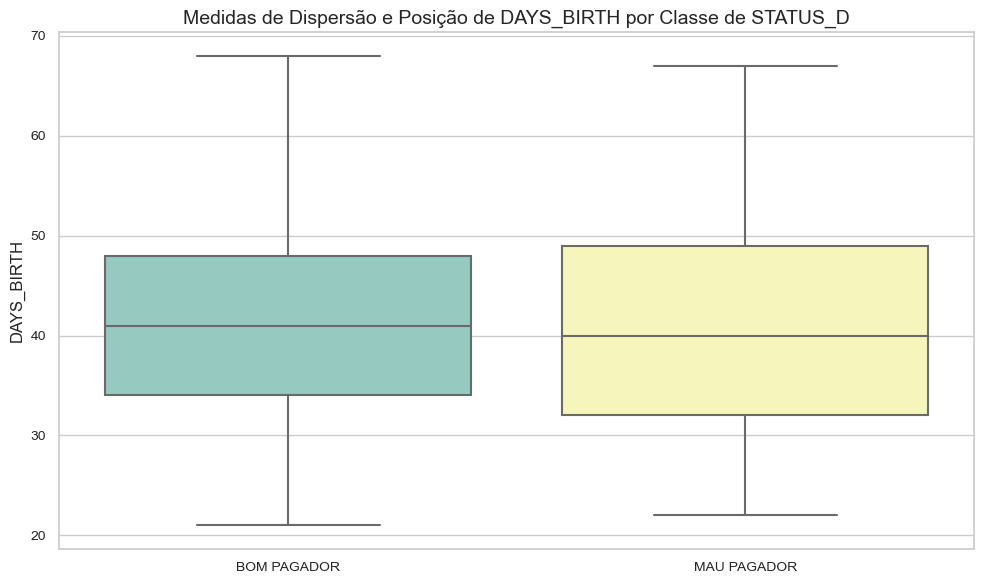

In [74]:
# Visualizando Graficamente
box_graf(dataset=db, independente='DAYS_BIRTH', resposta='STATUS_D')

Podemos verificar que a média de idade dos clientes é de 41 anos com desvio padrão de 9 anos aproximadamente. A mediana possui mesmo valor da média o que caracteriza uma curva próxima da normal.

Vamos aplicar uma escala Likert para relacionar as Faixas Etárias com a nossa variável de inadimplência.

In [75]:
# Criando as Faixas de Valor da Escala Likert
faixas = [20, 30, 40, 50, 60 , 70]
db['Faixa_Etaria'] = pd.cut(db['DAYS_BIRTH'], bins=faixas)

# Dropando a Variável de Origem
db.drop('DAYS_BIRTH', axis=1, inplace=True)

# Visualizando o Dataset pela Escala criada
db.groupby(db['STATUS_D']).value_counts()

STATUS_D     Faixa_Etaria
BOM PAGADOR  (30, 40]        114737
             (40, 50]        103427
             (50, 60]         58571
             (20, 30]         48867
             (60, 70]          6961
MAU PAGADOR  (30, 40]          1593
             (40, 50]          1337
             (20, 30]           910
             (50, 60]           903
             (60, 70]            77
Name: count, dtype: int64

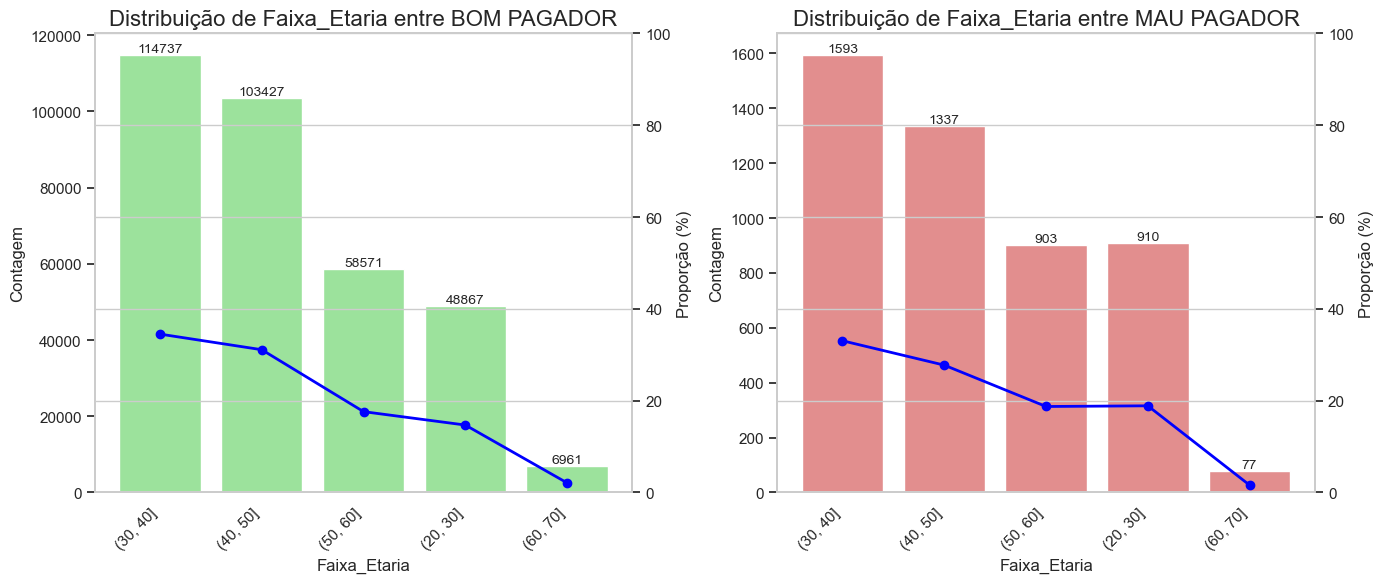

In [76]:
# Visualização das Categorias por Inadimplência
comp_cat(dataset=db, independente='Faixa_Etaria', resposta='STATUS_D')

In [77]:
# Desenhando uma Tabela Cruzada Referenciando a Inadimplência
tabela_cruzada1 = pd.crosstab(db['STATUS_D'], db['Faixa_Etaria'], normalize='index', margins=True )

# Desenhando a Tabela Cruzada referenciando a Faixa Etária dos Clientes
tabela_cruzada2 = pd.crosstab(db['Faixa_Etaria'], db['STATUS_D'], normalize='index', margins=True )
print(f'Tabela Cruzada Inadimplência \n{tabela_cruzada1}\n\nTabela Cruzada Faixa Etária dos Clientes\n{tabela_cruzada2}')

Tabela Cruzada Inadimplência 
Faixa_Etaria  (20, 30]  (30, 40]  (40, 50]  (50, 60]  (60, 70]
STATUS_D                                                      
BOM PAGADOR   0.146941  0.345008  0.311000  0.176120  0.020931
MAU PAGADOR   0.188797  0.330498  0.277386  0.187344  0.015975
All           0.147539  0.344801  0.310519  0.176280  0.020861

Tabela Cruzada Faixa Etária dos Clientes
STATUS_D      BOM PAGADOR  MAU PAGADOR
Faixa_Etaria                          
(20, 30]         0.981718     0.018282
(30, 40]         0.986306     0.013694
(40, 50]         0.987238     0.012762
(50, 60]         0.984817     0.015183
(60, 70]         0.989059     0.010941
All              0.985714     0.014286


Analisando as tabelas cruzadas podemos considerar:
- Clientes na Faixa Etária de 51 a 60 anos, aparentemente são mais inadimplentes que as demais faixas etárias.
- Clientes na Faixa Etária de 61 a 70 anos, aparentemente são menos inadimplentes que as demais faixas etárias.

Vamos confirmar as afirmações analisando se existe associação significativa e significância nas comparações das proporções.

In [78]:
# Teste de Associação Qui-Quadrado
teste_qui(dataset=db, independente='Faixa_Etaria', resposta='STATUS_D')

Teste Qui-Quadrado

Hipóteses:
H0: Existe associação significativa entre as categorias da variável STATUS_D em termos de inadimplência.
H1: Não Existe associação significativa entre as categorias da variável STATUS_D em termos de inadimplência.

A Estatística p_value = 1.1334112476773719e-17, portanto não rejeitamos H0. Existe associação significativa entre as categorias da variável STATUS_D em termos de inadimplência.


In [79]:
# Teste de Proporção entre as Faixas  ANOVA
test_anova_1_via(crosstab=tabela_cruzada2, independente='Faixa_Etaria', resposta='STATUS_D')

Resultado do Teste ANOVA de 1 Via:
-----------------------------------
Estatística F: 7.886999883568288
Valor p: 0.022900142457554014
Há evidências suficientes para concluir que a proporção de inadimplência é diferente entre as categorias de Faixa_Etaria_1 (p-valor < 0.05).


Como podemos observar, é possível afirmar que os Clientes mais inadimplentes estão na faixa etária de 51 a 60 anos, enquanto os clientes menos inadimplentes estão na faixa entre 61 e 70 anos.

#### Tempo Empregado

Primeiramente vamos analisar as estatísticas de posição e dispersão, visto que é uma variável numérica.

In [80]:
# Construindo um Subset do Dataset
de = dataset[['DAYS_EMPLOYED', 'STATUS_D']]

# Tranformando os dias em Anos
de['DAYS_EMPLOYED'] = abs(de['DAYS_EMPLOYED']// 365)

In [81]:
# Estatísticas de Posição e Dispersão
de.describe()

,DAYS_EMPLOYED
count,337383.000000
mean,7.871597
std,6.476659
min,1.000000
25%,3.000000
50%,6.000000
75%,10.000000
max,44.000000


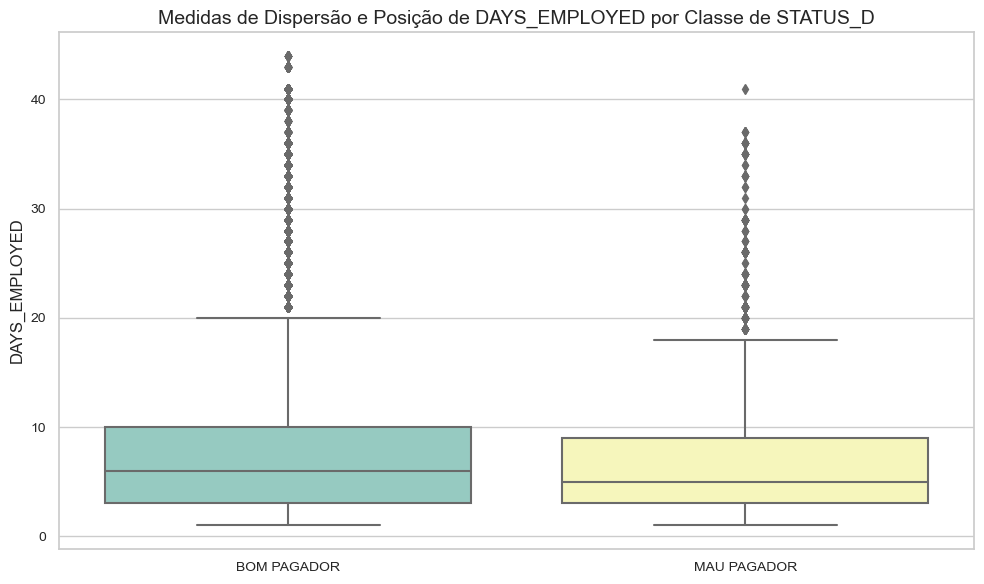

In [82]:
# Visualizando o Boxplot
box_graf(dataset=de, independente='DAYS_EMPLOYED', resposta='STATUS_D')

Podemos observar a incidência de muitos outliers em nossa base de dados. Vamos aplicar a técnica dos Quartis e refazer nossas estatísticas de posição e dispersão.

In [83]:
# Excluindo os Outliers
de = elimina_outliers(dataset=de, independente='DAYS_EMPLOYED')

# Visualizando as Estatísticas
de.describe()

,DAYS_EMPLOYED
count,317524.000000
mean,6.723665
std,4.540715
min,1.000000
25%,3.000000
50%,6.000000
75%,9.000000
max,20.000000


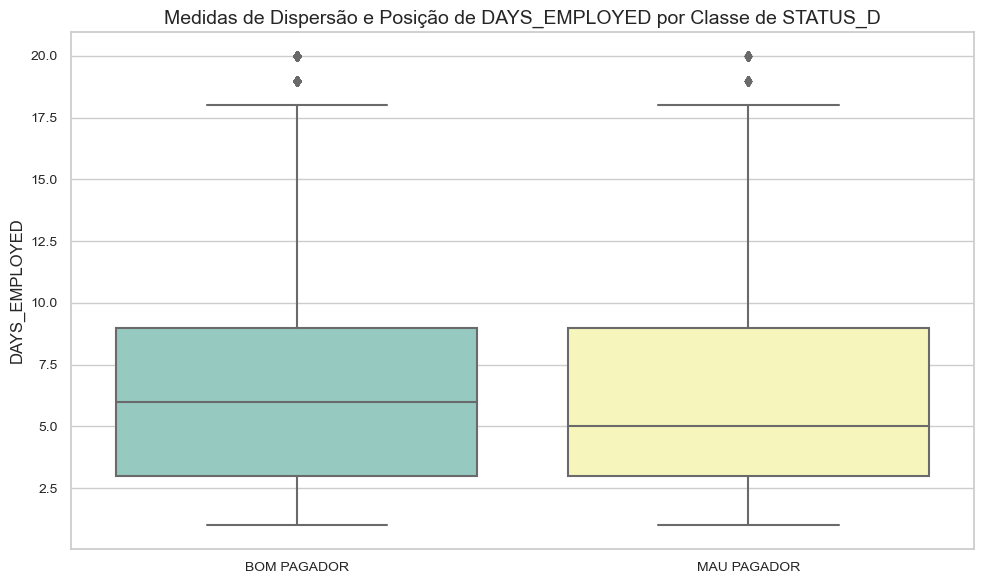

In [84]:
# Visualizando Graficamente
box_graf(dataset=de, independente='DAYS_EMPLOYED', resposta='STATUS_D')

Agora podemos ver com clareza que a média de tempo empregado em nossa base é de 6.35 anos com desvio padrão de 4 anos, sendo a mediana nos 5 anos de trabalho.

Agora vamos aplicar a mesma técnica de feature engineering que fizemos em DAYS_BIRTH. Assim poderemos identificar qual a faixa de tempo empregado possui maior inadimplência.

In [85]:
# Criando as Faixas de Valor da Escala Likert
faixas = [0, 5, 10, 15, 20]
de['Tempo_Empregado'] = pd.cut(de['DAYS_EMPLOYED'], bins=faixas)

# Dropando a Variável de Origem
de.drop('DAYS_EMPLOYED', axis=1, inplace=True)

# Visualizando o Dataset pela Escala criada
de.groupby(de['STATUS_D']).value_counts()

STATUS_D     Tempo_Empregado
BOM PAGADOR  (0, 5]             151494
             (5, 10]            101075
             (10, 15]            42565
             (15, 20]            17844
MAU PAGADOR  (0, 5]               2653
             (5, 10]              1161
             (10, 15]              554
             (15, 20]              178
Name: count, dtype: int64

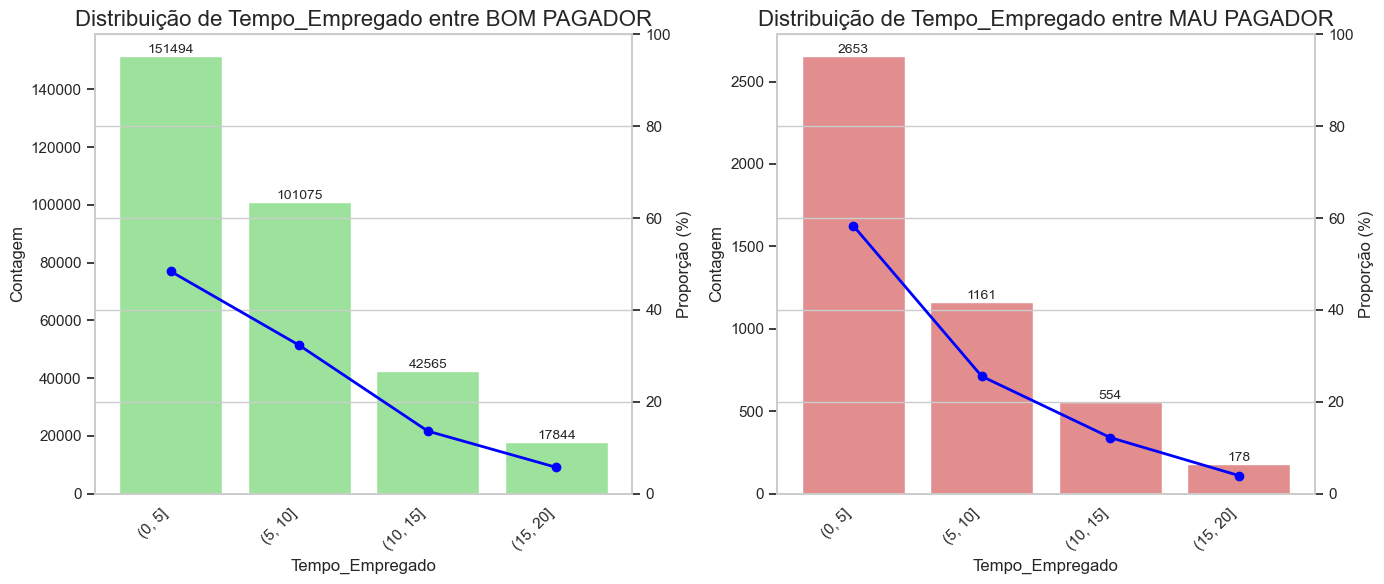

In [86]:
# Visualização das Categorias por Inadimplência
comp_cat(dataset=de, independente='Tempo_Empregado', resposta='STATUS_D')

In [87]:
# Desenhando uma Tabela Cruzada Referenciando a Inadimplência
tabela_cruzada1 = pd.crosstab(de['STATUS_D'], de['Tempo_Empregado'], normalize='index', margins=True )

# Desenhando a Tabela Cruzada referenciando o Tempo Empregado dos Clientes
tabela_cruzada2 = pd.crosstab(de['Tempo_Empregado'], de['STATUS_D'], normalize='index', margins=True )
print(f'Tabela Cruzada Inadimplência \n{tabela_cruzada1}\n\nTabela Cruzada Tempo Empregado dos Clientes\n{tabela_cruzada2}')

Tabela Cruzada Inadimplência 
Tempo_Empregado    (0, 5]   (5, 10]  (10, 15]  (15, 20]
STATUS_D                                               
BOM PAGADOR      0.484040  0.322946  0.136000  0.057014
MAU PAGADOR      0.583590  0.255389  0.121865  0.039155
All              0.485466  0.321979  0.135798  0.056758

Tabela Cruzada Tempo Empregado dos Clientes
STATUS_D         BOM PAGADOR  MAU PAGADOR
Tempo_Empregado                          
(0, 5]              0.982789     0.017211
(5, 10]             0.988644     0.011356
(10, 15]            0.987152     0.012848
(15, 20]            0.990123     0.009877
All                 0.985683     0.014317


Analisando as tabelas cruzadas podemos considerar:
- Clientes com tempo de trabalho entre 16 e 20 anos, aparentemente são menos inadimplentes que as demais faixas de tempo de trabalho.
- Clientes com tempo de trabalho entre 0 a 5 anos e 26 a 30 anos, aparentemente são mais inadimplentes que as demais faixas de tempo de trabalho.

Vamos confirmar as afirmações analisando se existe associação significativa e significância nas comparações das proporções.

In [88]:
# Teste de Associação Qui-Quadrado
teste_qui(dataset=de, independente='Tempo_Empregado', resposta='STATUS_D')

Teste Qui-Quadrado

Hipóteses:
H0: Existe associação significativa entre as categorias da variável STATUS_D em termos de inadimplência.
H1: Não Existe associação significativa entre as categorias da variável STATUS_D em termos de inadimplência.

A Estatística p_value = 3.0628746218160913e-40, portanto não rejeitamos H0. Existe associação significativa entre as categorias da variável STATUS_D em termos de inadimplência.


In [89]:
# Teste de Proporção entre as Faixas  ANOVA
test_anova_1_via(crosstab=tabela_cruzada2, independente='Tempo_Empregado', resposta='STATUS_D')

Resultado do Teste ANOVA de 1 Via:
-----------------------------------
Estatística F: 5.308037262738334
Valor p: 0.06077323348178548
Não há evidências suficientes para concluir que a proporção de inadimplência é diferente entre as categorias de Tempo_Empregado_1 (p-valor > 0.05).


Desta forma, não podemos afirmar que clientes com maiores tempos de trabalho são menos inadimplentes que as demais faixas, ou ainda que clientes com até 5 anos de trabalho são mais inadimplentes que as demais.

#### Proprietário de Celular

Esta Variável (FLAG_MOBIL) descreve um comportamento de "sim" ou "não", referente a propriedade de um aparelho celular. Vamos analisar como ela se relaciona com a variável resposta e verificar que conclusões podemos fazer.

In [90]:
# Criando um subset
fm = dataset[['FLAG_MOBIL', 'STATUS_D']]
fm.groupby(fm['STATUS_D']).value_counts()

STATUS_D     FLAG_MOBIL
BOM PAGADOR  1             332563
MAU PAGADOR  1               4820
Name: count, dtype: int64

A variável não possui significância para o estudo, visto que 100% dos Clientes desta base de dados, possui aparelhos celulares. Portanto descartaremos a mesma durante a preparação dos dados para construção dos modelos de ML.

##### Propriedade de Telefone Fixo no Trabalho

De forma análoga a variável anterior, FLAG_WORk_PHONE descreve um comportamento de "sim" (1) ou "não" (0), referente a propriedade de uma linha telefônica exclusiva no trabalho. Vamos analisar como ela se relaciona com a variável resposta e verficar quais conclusões podemos fazer.

In [91]:
# Criando um subset
fwp = dataset[['FLAG_WORK_PHONE', 'STATUS_D']]
fwp.groupby(fwp['STATUS_D']).value_counts()

STATUS_D     FLAG_WORK_PHONE
BOM PAGADOR  0                  239048
             1                   93515
MAU PAGADOR  0                    3514
             1                    1306
Name: count, dtype: int64

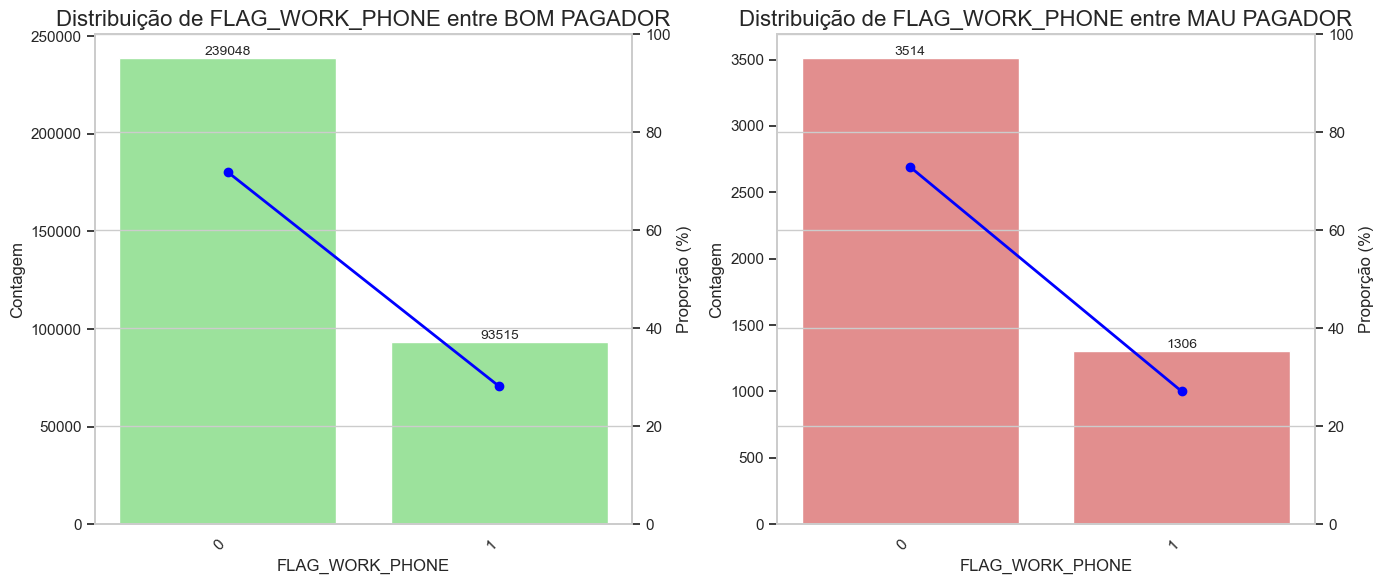

In [92]:
# Visualizando Graficamente em relação a Inadimplência
comp_cat(dataset=fwp, independente='FLAG_WORK_PHONE', resposta='STATUS_D')

In [93]:
# Desenhando uma Tabela Cruzada Referenciando a Inadimplência
tabela_cruzada1 = pd.crosstab(fwp['STATUS_D'], fwp['FLAG_WORK_PHONE'], normalize='index', margins=True )

# Desenhando a Tabela Cruzada referenciando a posse de Telefone Profissional dos Clientes
tabela_cruzada2 = pd.crosstab(fwp['FLAG_WORK_PHONE'], fwp['STATUS_D'], normalize='index', margins=True )
print(f'Tabela Cruzada Inadimplência \n{tabela_cruzada1}\n\nTabela Cruzada Propriedade de Telefone no Trabaho dos Clientes\n{tabela_cruzada2}')

Tabela Cruzada Inadimplência 
FLAG_WORK_PHONE         0         1
STATUS_D                           
BOM PAGADOR      0.718805  0.281195
MAU PAGADOR      0.729046  0.270954
All              0.718951  0.281049

Tabela Cruzada Propriedade de Telefone no Trabaho dos Clientes
STATUS_D         BOM PAGADOR  MAU PAGADOR
FLAG_WORK_PHONE                          
0                   0.985513     0.014487
1                   0.986227     0.013773
All                 0.985714     0.014286


Observando as Tabelas Cruzadas, podemos citar:
- Clientes com Telefone Fixo no Trabalho, aparentemente são menos inadimplentes que pessoas sem telefone fixo no trabalho.

Vamos testar essa hipótese para saber se existe associação entre as variáveis e se as proporções são significativas para afirmarmos a citação.

In [94]:
# Teste de Associação Qui-Quadrado
teste_qui(dataset=fwp, independente='FLAG_WORK_PHONE', resposta='STATUS_D')

Teste Qui-Quadrado

Hipóteses:
H0: Existe associação significativa entre as categorias da variável FLAG_WORK_PHONE em termos de inadimplência.
H1: Não Existe associação significativa entre as categorias da variável FLAG_WORK_PHONE em termos de inadimplência.

A Estatística p_value = 0.12014879692245603, portanto rejeitamos H0. Não Existe associação significativa entre as categorias da variável FLAG_WORK_PHONE em termos de inadimplência.


Como podemos verificar, não existe associação entre as variáveis e portanto não podemos afirmar que clientes proporietários de telefone fixo no trabalho são menos inadimplentes que clientes que não possuem o mesmo benefício.

#### Propriedade de Telefone Fixo Pessoal

De forma análoga a variável anterior, faremos os mesmos procedimentos e aplicaremos as mesmas técnicas.

In [95]:
# Criando um subset para Análise
fp = dataset[['FLAG_PHONE', 'STATUS_D']]
fp.groupby(fp['STATUS_D']).value_counts()

STATUS_D     FLAG_PHONE
BOM PAGADOR  0             233853
             1              98710
MAU PAGADOR  0               3357
             1               1463
Name: count, dtype: int64

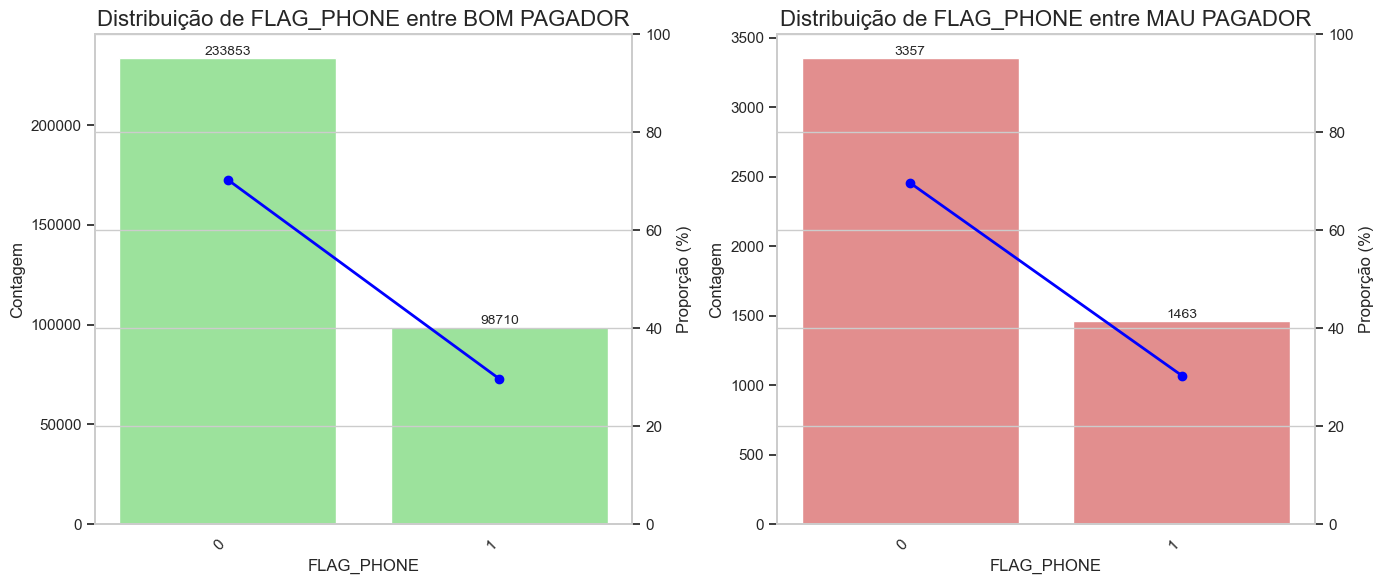

In [96]:
# Visualizando Graficamente em relação a Inadimplência
comp_cat(dataset=fp, independente='FLAG_PHONE', resposta='STATUS_D')

In [97]:
# Desenhando uma Tabela Cruzada Referenciando a Inadimplência
tabela_cruzada1 = pd.crosstab(fp['STATUS_D'], fp['FLAG_PHONE'], normalize='index', margins=True )

# Desenhando a Tabela Cruzada referenciando a posse de telefone pessoal dos Clientes
tabela_cruzada2 = pd.crosstab(fp['FLAG_PHONE'], fp['STATUS_D'], normalize='index', margins=True )
print(f'Tabela Cruzada Inadimplência \n{tabela_cruzada1}\n\nTabela Cruzada Propriedade de Telefone Pessoal dos Clientes\n{tabela_cruzada2}')

Tabela Cruzada Inadimplência 
FLAG_PHONE          0         1
STATUS_D                       
BOM PAGADOR  0.703184  0.296816
MAU PAGADOR  0.696473  0.303527
All          0.703088  0.296912

Tabela Cruzada Propriedade de Telefone Pessoal dos Clientes
STATUS_D    BOM PAGADOR  MAU PAGADOR
FLAG_PHONE                          
0              0.985848     0.014152
1              0.985395     0.014605
All            0.985714     0.014286


Novamente podemos testar se Cliente com Telefone Fixo Pessoal são mais inadimplentes que Clientes sem o mesmo recurso.

In [98]:
# Teste de Associação Qui-Quadrado
teste_qui(dataset=fp, independente='FLAG_PHONE', resposta='STATUS_D')

Teste Qui-Quadrado

Hipóteses:
H0: Existe associação significativa entre as categorias da variável FLAG_PHONE em termos de inadimplência.
H1: Não Existe associação significativa entre as categorias da variável FLAG_PHONE em termos de inadimplência.

A Estatística p_value = 0.31897629301508434, portanto rejeitamos H0. Não Existe associação significativa entre as categorias da variável FLAG_PHONE em termos de inadimplência.


Como podemos verificar no resultado do teste de hipótese aplicado, não podemos afirmar que Clientes com Telefone Fixo Pessoal, possuem maior inadimplência que Clientes sem o mesmo recurso.

#### Propriedade de Email Ativo

Novamente uma variável com mesmo modelo de análise anterior. Repetiremos as técnicas e procedimentos. Uma condição particular é que neste caso "sim" (0) e "não" (1).

In [99]:
# Criando um Subset de Análise
email = dataset[['FLAG_EMAIL', 'STATUS_D']]
email.groupby('STATUS_D').value_counts()

STATUS_D     FLAG_EMAIL
BOM PAGADOR  0             298745
             1              33818
MAU PAGADOR  0               4262
             1                558
Name: count, dtype: int64

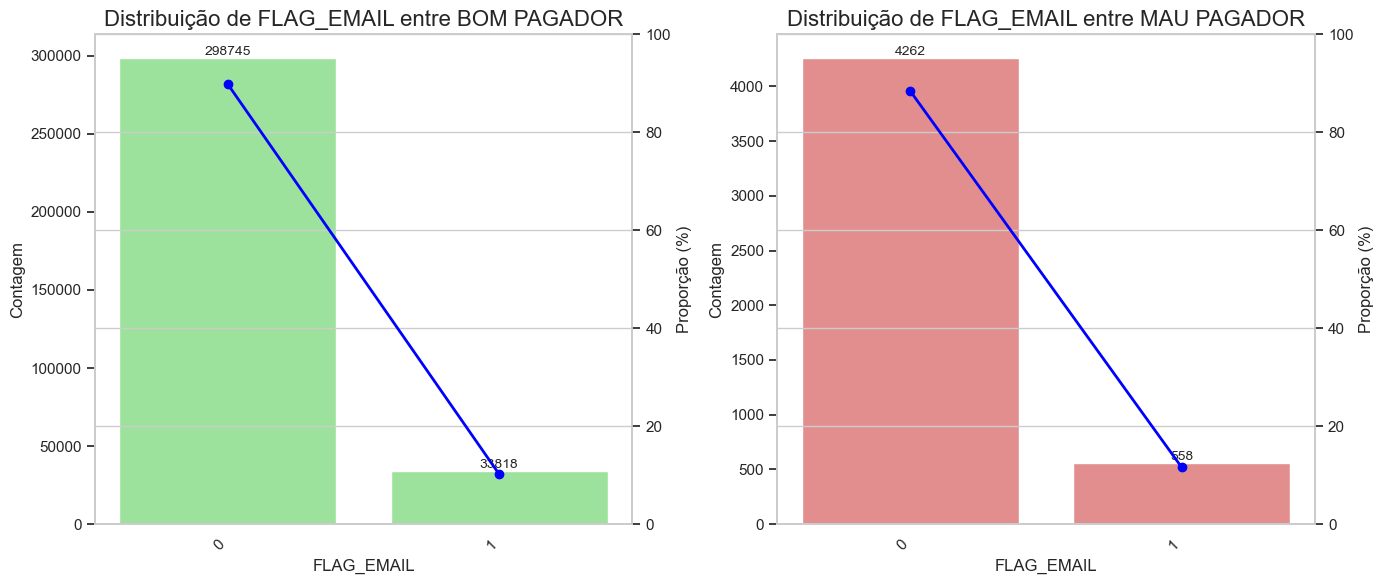

In [100]:
# Visualizando Graficamente a Variável por Inadimplência
comp_cat(dataset=email, independente='FLAG_EMAIL', resposta='STATUS_D')

In [101]:
# Desenhando uma Tabela Cruzada Referenciando a Inadimplência
tabela_cruzada1 = pd.crosstab(email['STATUS_D'], email['FLAG_EMAIL'], normalize='index', margins=True )

# Desenhando a Tabela Cruzada referenciando a propriedade de email dos Clientes
tabela_cruzada2 = pd.crosstab(email['FLAG_EMAIL'], email['STATUS_D'], normalize='index', margins=True )
print(f'Tabela Cruzada Inadimplência \n{tabela_cruzada1}\n\nTabela Cruzada Propriedade de Email dos Clientes\n{tabela_cruzada2}')

Tabela Cruzada Inadimplência 
FLAG_EMAIL          0         1
STATUS_D                       
BOM PAGADOR  0.898311  0.101689
MAU PAGADOR  0.884232  0.115768
All          0.898110  0.101890

Tabela Cruzada Propriedade de Email dos Clientes
STATUS_D    BOM PAGADOR  MAU PAGADOR
FLAG_EMAIL                          
0              0.985934     0.014066
1              0.983768     0.016232
All            0.985714     0.014286


Podemos verificar que aparentemente Clientes sem Email são mais inadimplentes que Clientes com este recurso. Vamos verificar se podemos afirmar estatísticamente essa citação.

In [102]:
# Teste de Associação Qui-Quadrado
teste_qui(dataset=email, independente='FLAG_EMAIL', resposta='STATUS_D')

Teste Qui-Quadrado

Hipóteses:
H0: Existe associação significativa entre as categorias da variável FLAG_EMAIL em termos de inadimplência.
H1: Não Existe associação significativa entre as categorias da variável FLAG_EMAIL em termos de inadimplência.

A Estatística p_value = 0.001452663608523143, portanto não rejeitamos H0. Existe associação significativa entre as categorias da variável FLAG_EMAIL em termos de inadimplência.


In [103]:
# Teste de Proporção
teste_prop(dataset=email, independente='FLAG_EMAIL', resposta='STATUS_D')

Teste de Proporção

Hipóteses:
H0: Existe diferença significativa nas proporções entre as categorias da variável FLAG_EMAIL em termos de inadimplência.
H1: Não Existe diferença significativa nas proporções entre as categorias da variável FLAG_EMAIL em termos de inadimplência.

A Estatística p_value = 0.0013, portanto não rejeitamos H0. Existe diferença significativa nas proporções entre as categorias da variável FLAG_EMAIL em termos de inadimplência.


Conforme podemos verificar nos testes de hipótese, é correto afirmar que Clientes que possuem email são menos inadimplentes que clientes que não possuem o mesmo recurso.

#### Profissão

Seguimos analisando as variáveis categóricas em relação a variável resposta. Vamos entender a frequência e proporção das categorias e avaliar se existe associação e significância estatística.

In [104]:
# Criando um Subset de Análise
prof = dataset[['OCCUPATION_TYPE', 'STATUS_D']]
prof.groupby('STATUS_D').value_counts()

STATUS_D     OCCUPATION_TYPE      
BOM PAGADOR  Laborers                 81945
             Core staff               47429
             Sales staff              44489
             Managers                 41041
             Drivers                  29428
             High skill tech staff    19523
             Accountants              16842
             Medicine staff           16052
             Cooking staff             8166
             Security staff            7644
             Cleaning staff            7205
             Private service staff     4285
             Low-skill Laborers        2205
             Secretaries               2006
             Waiters/barmen staff      1711
             HR staff                   989
             Realty agents              813
             IT staff                   790
MAU PAGADOR  Laborers                  1101
             Core staff                 655
             Managers                   644
             Sales staff                5

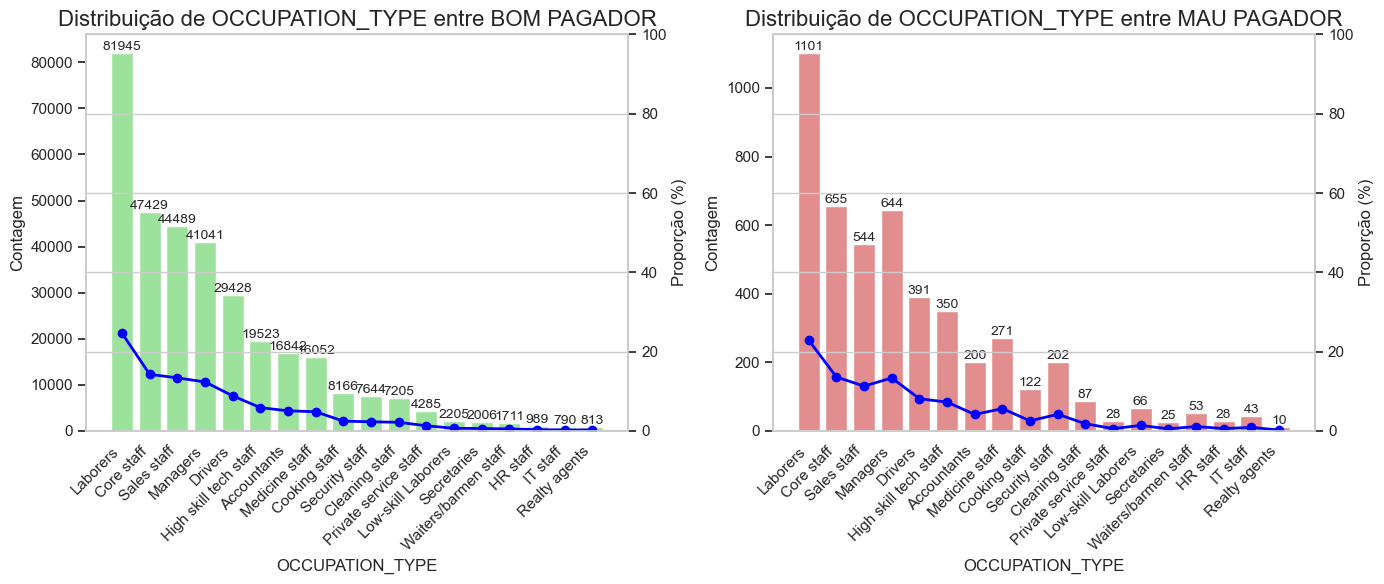

In [105]:
# Visualizando Graficamente a Variável por Inadimplência
comp_cat(dataset=prof, independente='OCCUPATION_TYPE', resposta='STATUS_D')

In [106]:
# Desenhando uma Tabela Cruzada Referenciando a Inadimplência
tabela_cruzada1 = pd.crosstab(prof['STATUS_D'], prof['OCCUPATION_TYPE'], normalize='index', margins=True )

# Desenhando a Tabela Cruzada referenciando a Profissão dos Clientes
tabela_cruzada2 = pd.crosstab(prof['OCCUPATION_TYPE'], prof['STATUS_D'], normalize='index', margins=True )
print(f'Tabela Cruzada Inadimplência \n{tabela_cruzada1}\n\nTabela Cruzada Profissão dos Clientes\n{tabela_cruzada2}')

Tabela Cruzada Inadimplência 
OCCUPATION_TYPE  Accountants  Cleaning staff  Cooking staff  Core staff  \
STATUS_D                                                                  
BOM PAGADOR         0.050643        0.021665       0.024555    0.142617   
MAU PAGADOR         0.041494        0.018050       0.025311    0.135892   
All                 0.050512        0.021613       0.024566    0.142521   

OCCUPATION_TYPE   Drivers  HR staff  High skill tech staff  IT staff  \
STATUS_D                                                               
BOM PAGADOR      0.088488  0.002974               0.058705  0.002375   
MAU PAGADOR      0.081120  0.005809               0.072614  0.008921   
All              0.088383  0.003014               0.058903  0.002469   

OCCUPATION_TYPE  Laborers  Low-skill Laborers  Managers  Medicine staff  \
STATUS_D                                                                  
BOM PAGADOR      0.246404            0.006630  0.123408        0.048268   
MAU PAGA

Observando as proporções podemos fazer algumas suposições para então posteriormente verificar:
1. Clientes com profissões em Tecnologia são os mais inadimplentes em relação as demais profissões.
2. Clientes com profissões em Serviços Privados (Autônomos) são os menos inadimplentes em relação as demais prodfissões.

Para validarmos as afirmações, precisamos saber se existe associação significativa entre a Variável Profissão e a Variável Resposta. Posteriormente, havendo associação, analisamos se a proporcionalidade é passiva de comparação.

In [107]:
# Teste de Associação Qui-Quadrado
teste_qui(dataset=prof, independente='OCCUPATION_TYPE', resposta='STATUS_D')

Teste Qui-Quadrado

Hipóteses:
H0: Existe associação significativa entre as categorias da variável OCCUPATION_TYPE em termos de inadimplência.
H1: Não Existe associação significativa entre as categorias da variável OCCUPATION_TYPE em termos de inadimplência.

A Estatística p_value = 3.5375876928670976e-57, portanto não rejeitamos H0. Existe associação significativa entre as categorias da variável OCCUPATION_TYPE em termos de inadimplência.


In [108]:
# Teste de Proporção entre as Profissões - ANOVA
test_anova_1_via(crosstab=tabela_cruzada2, independente='OCCUPATION_TYPE', resposta='STATUS_D')

Resultado do Teste ANOVA de 1 Via:
-----------------------------------
Estatística F: 45.43174405409804
Valor p: 9.5706764445457e-08
Há evidências suficientes para concluir que a proporção de inadimplência é diferente entre as categorias de OCCUPATION_TYPE_1 (p-valor < 0.05).


Portanto é correto afirmar que Clientes com as Profissões de Tecnologia são mais inadimplentes em relação as demais profissões. E que Clientes com profissões autônomas são menos inadimplentes do que as demais profissões de nossos dados.

#### Qtde de Membros na Familia

Sendo uma variável numérica, inicialmente vamos analisar as medidas de posição e dispersão da mesma.

In [109]:
# Criando um Subset de Análise
fm = dataset[['CNT_FAM_MEMBERS', 'STATUS_D']]

In [110]:
# Medidas de Posição e Dispersão
fm.describe()

,CNT_FAM_MEMBERS
count,337383.000000
mean,2.298512
std,0.939309
min,1.000000
25%,2.000000
50%,2.000000
75%,3.000000
max,20.000000


Podemos observar que a média do Tamanho Familiar é de 3 pessoas, visto que não temos como considerar números decimais, sendo o desvio padrão de 1 pessoa. A mediana se coloca logo próxima a média, considerando que arredondamos a média para cima. Vamos analisar graficamente.

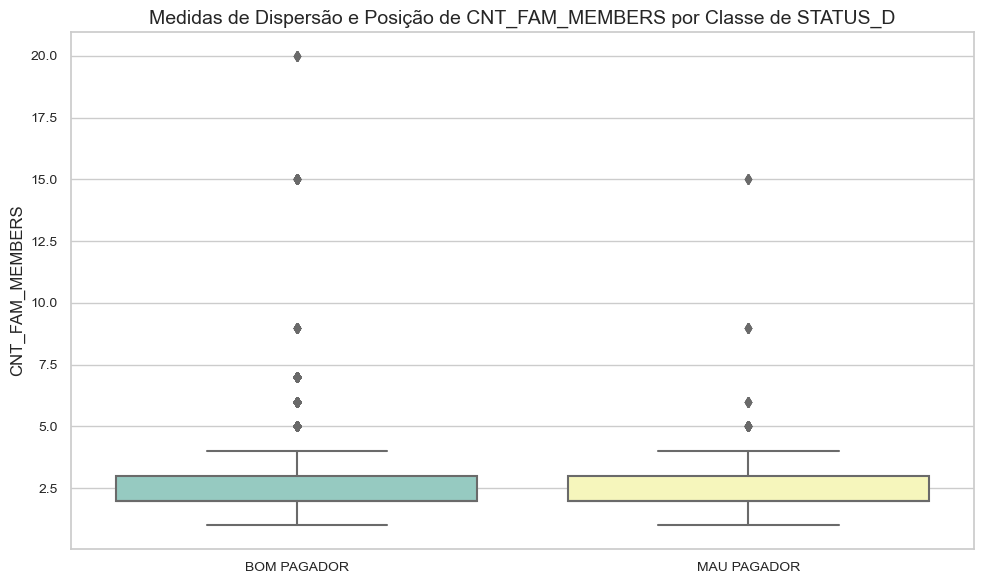

In [111]:
# Boxplot do Tamanho Familiar por Inadimplência
box_graf(dataset=fm, independente='CNT_FAM_MEMBERS', resposta='STATUS_D')

Podemos verificar que possuimos outliers atrapalhando nossos dados. Vamos eliminá-los utilizando a técnica baseada em Quartis (IQR) e analisar novamente nossas estatísticas.

In [112]:
# Eliminando Outilers de Tamanho Familiar
fm = elimina_outliers(dataset=fm, independente='CNT_FAM_MEMBERS')

# Verificando Estatísticas
fm.describe()

,CNT_FAM_MEMBERS
count,332315.000000
mean,2.252038
std,0.853190
min,1.000000
25%,2.000000
50%,2.000000
75%,3.000000
max,4.000000


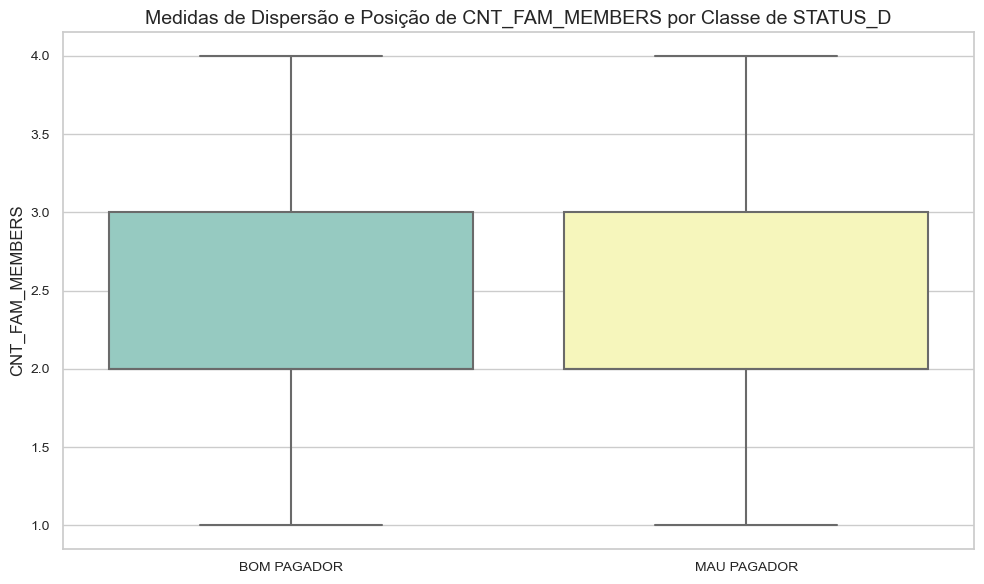

In [113]:
# Visualizando graficamente
box_graf(dataset=fm, independente='CNT_FAM_MEMBERS', resposta='STATUS_D')

Eliminado os outliers, temos um comportamento das estatisticas sem alteração, pois como não podemos considerar números decimais, somente inteiros, nada mudou dentro de nossas análises.

Agora vamos tratar os dados como categóricos, aplicando uma escala de likert e então verificar frequência e proporção, assim como associação entre as variáveis.

In [114]:
# Criando as Faixas de Valor da Escala Likert
faixas = [0, 1, 2, 3, 4]
fm['Tamanho_Familiar'] = pd.cut(fm['CNT_FAM_MEMBERS'], bins=faixas)

# Dropando a Variável de Origem
fm.drop('CNT_FAM_MEMBERS', axis=1, inplace=True)

# Visualizando o Dataset pela Escala criada
fm.groupby(fm['STATUS_D']).value_counts()

STATUS_D     Tamanho_Familiar
BOM PAGADOR  (1, 2]              170523
             (2, 3]               68803
             (0, 1]               54137
             (3, 4]               34097
MAU PAGADOR  (1, 2]                2394
             (2, 3]                 967
             (0, 1]                 953
             (3, 4]                 441
Name: count, dtype: int64

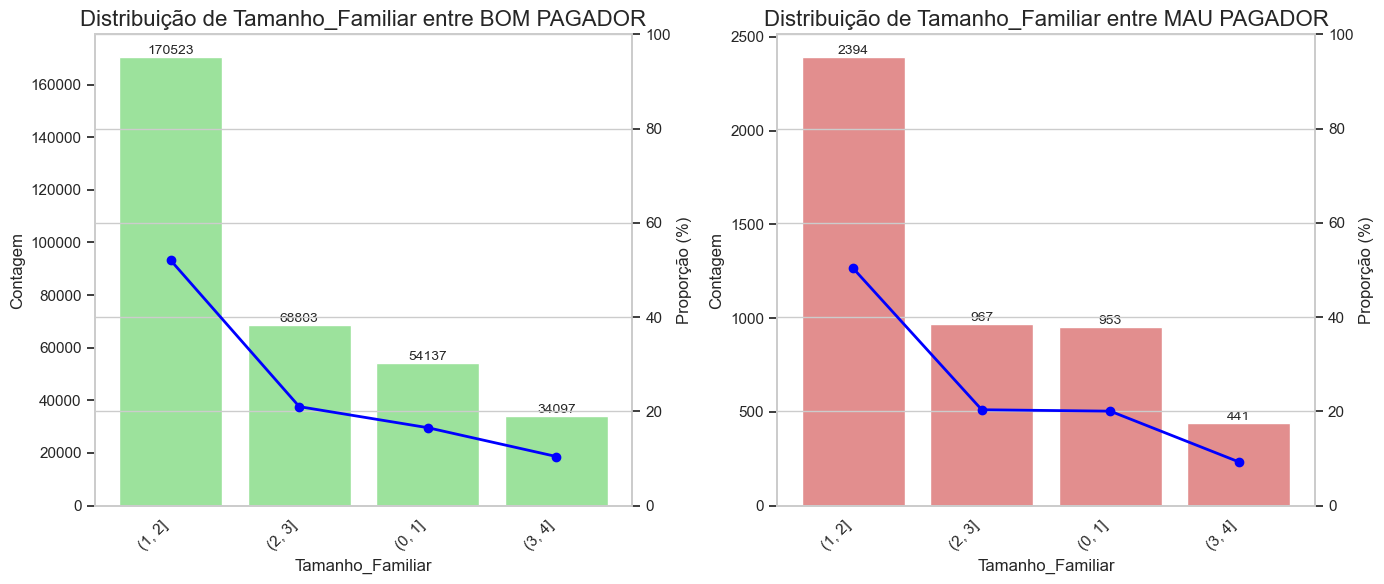

In [115]:
# Visualizando a Frequência dos dados Tamanho Familiar
comp_cat(dataset=fm, independente='Tamanho_Familiar', resposta='STATUS_D')

In [116]:
# Desenhando uma Tabela Cruzada Referenciando a Inadimplência
tabela_cruzada1 = pd.crosstab(fm['STATUS_D'], fm['Tamanho_Familiar'], normalize='index', margins=True )

# Desenhando a Tabela Cruzada referenciando o Tamanho Familiar
tabela_cruzada2 = pd.crosstab(fm['Tamanho_Familiar'], fm['STATUS_D'], normalize='index', margins=True )
print(f'Tabela Cruzada Inadimplência \n{tabela_cruzada1}\n\nTabela Cruzada Tamanho Familiar dos Clientes\n{tabela_cruzada2}')

Tabela Cruzada Inadimplência 
Tamanho_Familiar    (0, 1]    (1, 2]    (2, 3]    (3, 4]
STATUS_D                                                
BOM PAGADOR       0.165274  0.520586  0.210047  0.104094
MAU PAGADOR       0.200421  0.503470  0.203365  0.092744
All               0.165776  0.520341  0.209951  0.103932

Tabela Cruzada Tamanho Familiar dos Clientes
STATUS_D          BOM PAGADOR  MAU PAGADOR
Tamanho_Familiar                          
(0, 1]               0.982701     0.017299
(1, 2]               0.986155     0.013845
(2, 3]               0.986140     0.013860
(3, 4]               0.987231     0.012769
All                  0.985691     0.014309


Analisando nossas tabelas cruzadas, podemos supor:
1. Familias com 1 pessoa são mais inadimplentes em relação aos demais tamanhos familiareas.
2. Familias de 4 pessoas são menos inadimplentes que familias de demais tamanhos.

Vamos analisar as hipóteses verificando associação e proporção entre as variáveis.

In [117]:
# Teste de Associação Qui-Quadrado
teste_qui(dataset=fm, independente='Tamanho_Familiar', resposta='STATUS_D')

Teste Qui-Quadrado

Hipóteses:
H0: Existe associação significativa entre as categorias da variável STATUS_D em termos de inadimplência.
H1: Não Existe associação significativa entre as categorias da variável STATUS_D em termos de inadimplência.

A Estatística p_value = 1.2592227649958156e-09, portanto não rejeitamos H0. Existe associação significativa entre as categorias da variável STATUS_D em termos de inadimplência.


In [118]:
# Teste de Proporção entre os diferentes tamanhos familiares - ANOVA
test_anova_1_via(crosstab=tabela_cruzada2, independente='Tamanho_Familiar', resposta='STATUS_D')

Resultado do Teste ANOVA de 1 Via:
-----------------------------------
Estatística F: 5.296498463069741
Valor p: 0.06098229579221423
Não há evidências suficientes para concluir que a proporção de inadimplência é diferente entre as categorias de Tamanho_Familiar_1 (p-valor > 0.05).


Portanto é incorreto afirmar que Familias de 1 pessoa são mais inadimplentes que familias maiores. Assim como familias de 4 pessoas são menos inadimplentes em relação aos demais tamanhos familiares de nossos dados.

#### Receita

Sendo uma variável numérica, inicialmente vamos analisar as medidas de posição e dispersão da mesma.

In [119]:
# Criando um Subset de Análise
rec = dataset[['AMT_INCOME_TOTAL', 'STATUS_D']]
rec['STATUS_D'] = rec['STATUS_D'].astype('category')

In [120]:
# Medidas de Posição e Dispersão
rec.describe()

,AMT_INCOME_TOTAL
count,3.373830e+05
mean,1.971109e+05
std,1.042586e+05
min,2.700000e+04
25%,1.350000e+05
50%,1.800000e+05
75%,2.295000e+05
max,1.575000e+06


Podemos verificar que na média de nossa amostra, os clientes recebem 197 mil dólares anuais, com a mediana muito próxima a 180 mil dólares anuais. Vamos visualizar os dados em um boxplot!

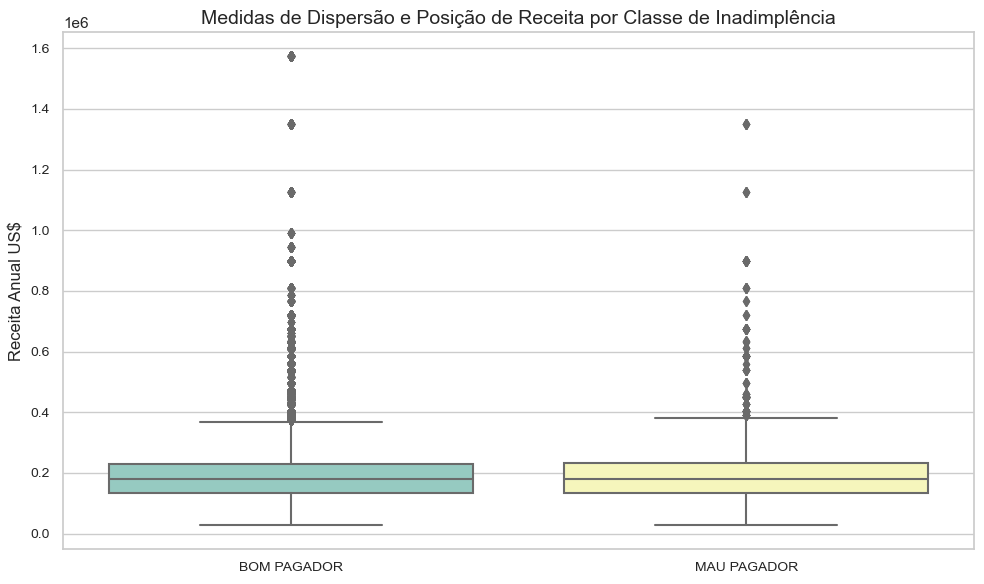

In [121]:
# Construindo o boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=rec, x="STATUS_D", y="AMT_INCOME_TOTAL", palette="Set3")

# Formatação para apresentação 

# Tema
sns.set_theme(style="whitegrid", palette="pastel")

# Título
plt.title("Medidas de Dispersão e Posição de Receita por Classe de Inadimplência", fontsize=14)

# Eixos
plt.xlabel("", fontsize=12)
plt.ylabel("Receita Anual US$", fontsize=12)

# Fonte
plt.tick_params(labelsize=10)

# Margens
plt.tight_layout()

# Mostrar o gráfico
plt.show()

Podemos verificar a incidência de outliers em nossos dados. Vamos tratar utilizando a técnica dos Quartis e refazer nossas estatísticas.

In [122]:
# Eliminando os Outliers
rec = elimina_outliers(dataset=rec, independente='AMT_INCOME_TOTAL')

# Visualizando as Estatísticas
rec.describe()

,AMT_INCOME_TOTAL
count,320574.000000
mean,181374.672500
std,71528.242545
min,27000.000000
25%,135000.000000
50%,171000.000000
75%,225000.000000
max,369000.000000


Perceba que passamos a uma média de 181 mil dólares anuais com desvio mais justo de 71 mil dólares e uma mediana de 171 mil dólares, muito próxima a média. Vamos visualizar um novo boxplot.

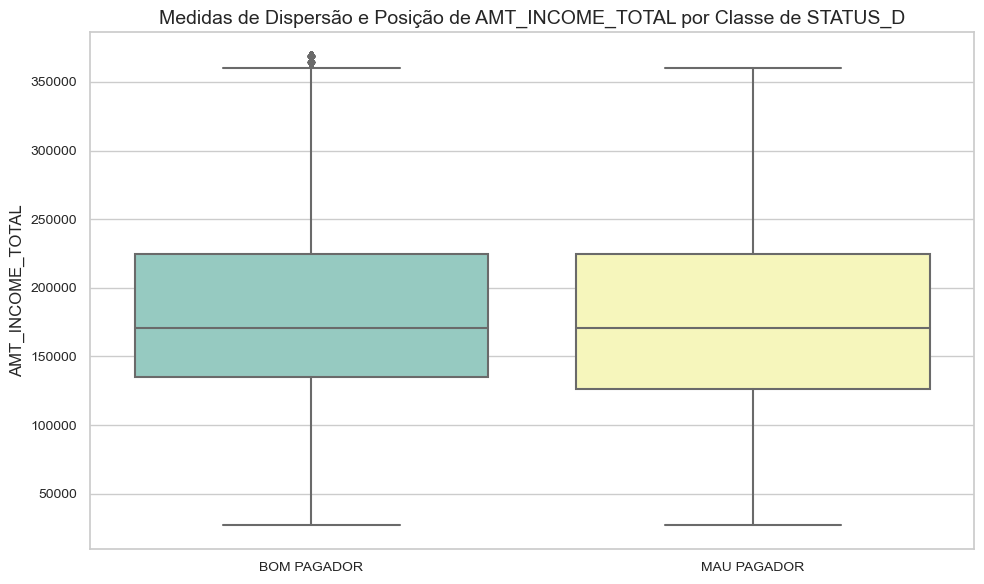

In [123]:
# Boxplot para Receita por Inadimplência
box_graf(dataset=rec, independente='AMT_INCOME_TOTAL', resposta='STATUS_D')

Agora, vamos olhar os dados por outra vertente, utilizando da mesma estratégia  aplicada a Tamanho Familiar, pois temos uma distribuição muito desforme devido a dispersão dos dados numéricos. Sendo assim, vamos aplicar uma escala likert para analisar em relação a variável resposta inadimplência.

In [124]:
# Criando as Faixas de Valor da Escala Likert
faixas = [0, 50000, 100000, 150000, 200000, 250000, 300000]
rec['Receita'] = pd.cut(rec['AMT_INCOME_TOTAL'], bins=faixas)

# Dropando a Variável de Origem
rec.drop('AMT_INCOME_TOTAL', axis=1, inplace=True)

# Visualizando o Dataset pela Escala criada
rec.groupby(rec['STATUS_D']).value_counts()

STATUS_D     Receita         
BOM PAGADOR  (100000, 150000]    88464
             (150000, 200000]    72328
             (200000, 250000]    66374
             (50000, 100000]     33073
             (250000, 300000]    29299
             (0, 50000]           1348
MAU PAGADOR  (100000, 150000]     1270
             (200000, 250000]     1030
             (150000, 200000]      984
             (250000, 300000]      483
             (50000, 100000]       449
             (0, 50000]             19
Name: count, dtype: int64

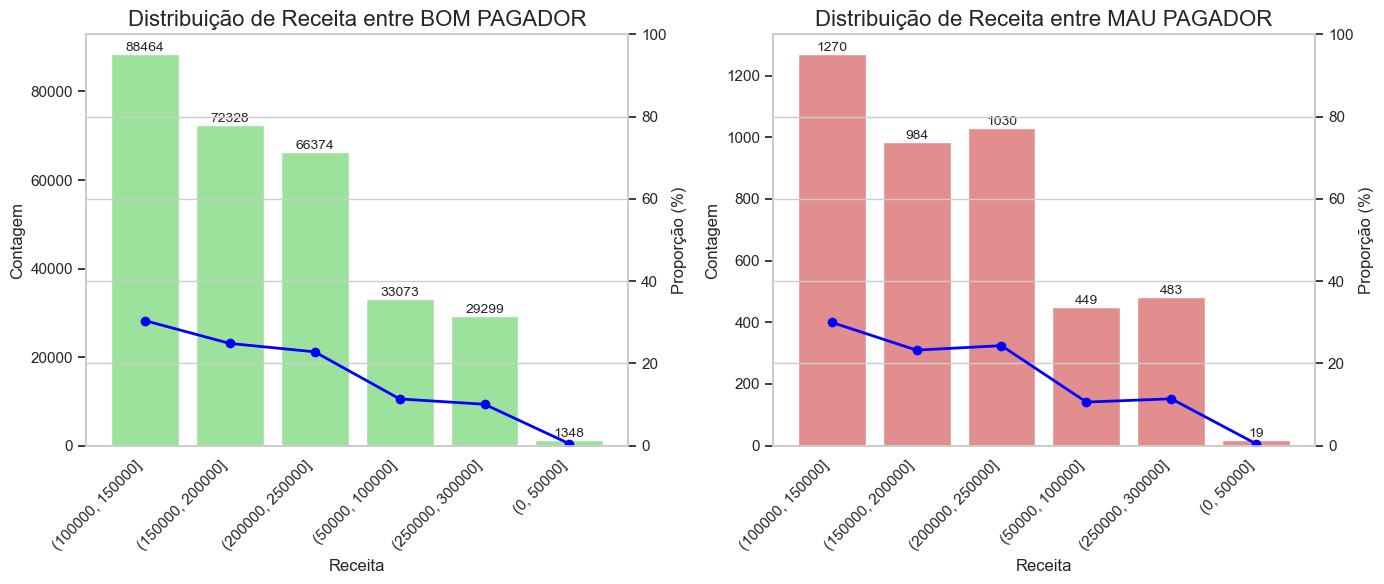

In [125]:
# Visualizando as Receitas por Inadimplência
comp_cat(dataset=rec, independente='Receita', resposta='STATUS_D')

In [126]:
# Desenhando uma Tabela Cruzada Referenciando a Inadimplência
tabela_cruzada1 = pd.crosstab(rec['STATUS_D'], rec['Receita'], normalize='index', margins=True )

# Desenhando a Tabela Cruzada referenciando a Receita
tabela_cruzada2 = pd.crosstab(rec['Receita'], rec['STATUS_D'], normalize='index', margins=True )
print(f'Tabela Cruzada Inadimplência \n{tabela_cruzada1}\n\nTabela Cruzada Receita dos Clientes\n{tabela_cruzada2}')

Tabela Cruzada Inadimplência 
Receita      (0, 50000]  (50000, 100000]  (100000, 150000]  (150000, 200000]  \
STATUS_D                                                                       
BOM PAGADOR    0.004634         0.113697          0.304119          0.248647   
MAU PAGADOR    0.004486         0.106021          0.299882          0.232349   
All            0.004632         0.113587          0.304058          0.248413   

Receita      (200000, 250000]  (250000, 300000]  
STATUS_D                                         
BOM PAGADOR          0.228179          0.100723  
MAU PAGADOR          0.243211          0.114050  
All                  0.228394          0.100915  

Tabela Cruzada Receita dos Clientes
STATUS_D          BOM PAGADOR  MAU PAGADOR
Receita                                   
(0, 50000]           0.986101     0.013899
(50000, 100000]      0.986606     0.013394
(100000, 150000]     0.985847     0.014153
(150000, 200000]     0.986578     0.013422
(200000, 250000]     0.9

Pelos resultado que obtivemos, podemos supor que:
1. Clientes com maior Receita são mais inadimplentes que os demais clientes com receitas menores.
2. Clientes com receitas entre 50k US$ e 100k US$ anuais, são menos inadimplentes que as demais faixas de Receita.

Vamos verificar as suposições com os testes de hipótese para associação entre variáveis categóricas e de proporção.

In [127]:
# Teste de Associação Qui-Quadrado
teste_qui(dataset=rec, independente='Receita', resposta='STATUS_D')

Teste Qui-Quadrado

Hipóteses:
H0: Existe associação significativa entre as categorias da variável STATUS_D em termos de inadimplência.
H1: Não Existe associação significativa entre as categorias da variável STATUS_D em termos de inadimplência.

A Estatística p_value = 0.0025158960540457524, portanto não rejeitamos H0. Existe associação significativa entre as categorias da variável STATUS_D em termos de inadimplência.


In [128]:
# Teste de Proporção entre os diferentes tamanhos familiares - ANOVA
test_anova_1_via(crosstab=tabela_cruzada2, independente='Receita', resposta='STATUS_D')

Resultado do Teste ANOVA de 1 Via:
-----------------------------------
Estatística F: 10.59125548681036
Valor p: 0.008655475682334286
Há evidências suficientes para concluir que a proporção de inadimplência é diferente entre as categorias de Receita_1 (p-valor < 0.05).


Conforme vemos, é possivel afirmar que Clientes com as maiores Receitas são mais inadimplentes que as demais faixas de receitas de Clientes. Assim como, Clientes com receitas entre 50k-100K US$ anuais são menos inadimplentes que as demais faixas de receita.

#### Análise de Multicolinearidade

Após as análises individuais das variáveis em relação a variável resposta, vamos precisar checar a multicolinearidade das variáveis, ou seja se existe associação entre elas. Com essa informação, podemos reduzir o número de variáveis em nosso modelo futuro, visto que a multicolinearidade tendencia os resultados do nosso modelo de ML.

In [129]:
# Preparando o Dataset

# Criando o Subset de Trabalho
var_cats = dataset.iloc[:,1:-1]

# Escalas Likert
el_receita = [0, 50000, 100000, 150000, 200000, 250000, 300000]
el_idade = [20, 30, 40, 50, 60 , 70]
el_temp_emp = [0, 5, 10, 15, 20]
el_men_fam = [0, 1, 2, 3, 4]

# Ajustando o dataset para as escalas likert
var_cats['Receita'] = pd.cut(var_cats['AMT_INCOME_TOTAL'], bins=el_receita)
var_cats['Idade'] = pd.cut(abs(var_cats['DAYS_BIRTH']// 365), bins=el_idade)
var_cats['Tempo_Empregado'] = pd.cut(abs(var_cats['DAYS_EMPLOYED']// 365), bins=el_temp_emp)
var_cats['Tamanho_Familiar'] = pd.cut(var_cats['CNT_FAM_MEMBERS'], bins=el_men_fam)
var_cats['Filhos'] = var_cats['CNT_CHILDREN'].apply(categ_filhos)


# Dropando as Colunas de Origem
var_cats.drop('AMT_INCOME_TOTAL', axis=1, inplace=True)
var_cats.drop('DAYS_BIRTH', axis=1, inplace=True)
var_cats.drop('DAYS_EMPLOYED', axis=1, inplace=True)
var_cats.drop('CNT_FAM_MEMBERS', axis=1, inplace=True)
var_cats.drop(labels='CNT_CHILDREN', axis=1, inplace=True)
var_cats.drop(labels='FLAG_MOBIL', axis=1, inplace=True)

# Ajustando o Nome das Colunas
new_names = ['Genero', 'Prop:Carro', 'Prop:Casa', 'Orig_Receita', 'Educacao', 'Estado_Civil', 'Tipo_Moradia', 'Prop:Tel_Prof', 'Prop:Tel_Pes', 'Prop:Email', 'Profissao', 'Receita', 'Idade', 'Tempo_Empregado', 'Tamanho_Familiar', 'Filhos']
var_cats.columns = new_names
var_cats = var_cats.astype('category')
var_cats.info(verbose=True)



<class 'pandas.core.frame.DataFrame'>
Index: 337383 entries, 31 to 486161
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   Genero            337383 non-null  category
 1   Prop:Carro        337383 non-null  category
 2   Prop:Casa         337383 non-null  category
 3   Orig_Receita      337383 non-null  category
 4   Educacao          337383 non-null  category
 5   Estado_Civil      337383 non-null  category
 6   Tipo_Moradia      337383 non-null  category
 7   Prop:Tel_Prof     337383 non-null  category
 8   Prop:Tel_Pes      337383 non-null  category
 9   Prop:Email        337383 non-null  category
 10  Profissao         337383 non-null  category
 11  Receita           295121 non-null  category
 12  Idade             337383 non-null  category
 13  Tempo_Empregado   317524 non-null  category
 14  Tamanho_Familiar  332315 non-null  category
 15  Filhos            337383 non-null  category
dtypes: cat

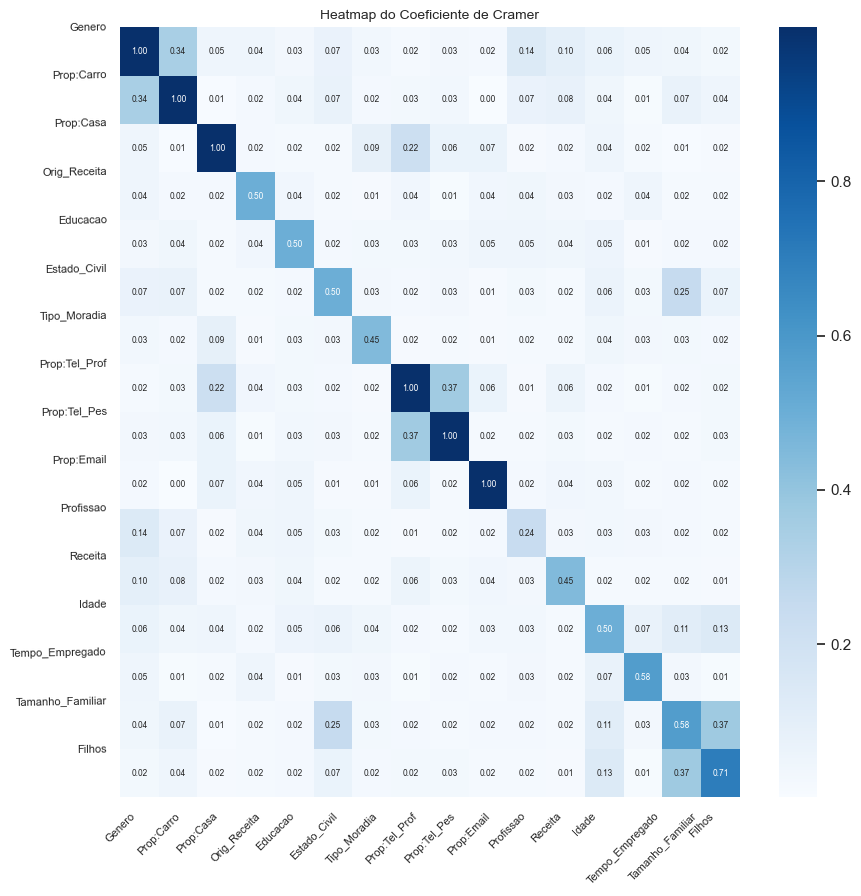

In [130]:
# Analisando a Multicolinearidade
matriz_coef_cramer(dataframe=var_cats)


Utilizamos o Coeficiente de Cramer para construir o heatmap e identificar quais variáveis poderiam ter multicolinearidade, ou seja, correlação entre si, porém percebemos que todas possuem baixa correlação o que desconsidera a hipótese. Vamos continuar nosso projeto, finalizando a análise de dados e resumindo os insights encontrados.

#### Resultado da Análise de Dados

Vamos resumir os insights que conseguimos identificar em nossos dados. São informações que podem ser úteis para a área de crédito, gestores ou mesmo analistas de crédito em suas análises e prospecções.

1. Clientes do Gênero Masculino são mais inadimplentes que Clientes do Gênero Feminino.
2. 

### Pré Processamento de Dados

In [131]:
# A realizar:
#TODO - Fazer uma nova cópia do dataset original
#TODO - Retirar a coluna ID
#TODO - Retirar a Variável Propriedade Celular
#TODO - Retirar os outliers das variáveis numericas (Tamanho Familiar, Tempo Empregado, Renda, Idade e Filhos)
#TODO - Categorizar todas as variáveis
#TODO - Aplicar LabelEncoding tranformando todas as classes em números [0, 1, 2..., n]
#TODO - Despivotar todas as variáveis em Variáveis Dummys
#TODO - Aplicar Random Forest para identificar as variáveis de maior importância para uma modelagem linear
#TODO - Excluir as Variáveis menos relevantes
#TODO - Dividir o Dataset resultante em Treino, Validacão e Teste
#TODO - Verificar o Balanceamento do Dataset de Treino
#TODO - (Opcional) Balancear o dataset de Treino com dados sintéticos e analisar a resposta dos modelos em um segundo momento.

### Construindo Modelos de Machine Learning

In [132]:
# A fazer:
#TODO - Contruir um Modelo de ML utilizando Regressão Logística
#TODO - Construir um Modelo de ML utilizando SVM - Suport Vector Machine

### Avaliação dos Modelos

In [133]:
# A fazer:
#TODO - Definir quais as métricas que vamos utilizar para comparar os modelos e porque!
#TODO - Comparar as Métricas entre Modelos e definir qual o modelo será utilizado
#TODO - Aplicar dados de Teste e Medir a Performance do Modelo Escolhido, comparando com os resultados dos dados de teste.

### Conclusão do Projeto

In [134]:
# A Fazer:
#TODO - Discutir as dificuldades e melhorias possíveis para os resultados alcançados
#TODO - Descrever oportunidades de novos estudos
#TODO - Concluir o Projeto